In [1]:
%%capture
!pip install camel_tools conllu qalsadi
!camel_data -i all
!pip install networkx arabic_reshaper
!pip install qalsadi

In [2]:
%%capture
!camel_data -i all

In [ ]:
!pip install python-bidi

### Required Modules

In [4]:
from camel_tools.tagger.default import DefaultTagger
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.morphology.database import MorphologyDB
import conllu
import camel_tools.tokenizers.word as tokenizer
from camel_tools.utils.normalize import normalize_teh_marbuta_ar,normalize_alef_ar,normalize_alef_maksura_ar
import qalsadi.lemmatizer
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import arabic_reshaper
from bidi.algorithm import get_display
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gensim
from torch.utils.data import random_split
from sklearn.metrics import f1_score
import emoji
from tqdm.notebook import tqdm
tqdm.pandas()
import time
from sklearn.metrics import f1_score, confusion_matrix
from camel_tools.utils.dediac import dediac_ar
mle = MLEDisambiguator.pretrained()


### ***Title***
# Arabic POS with NetworkX in Articles

### Description
- **Objective:** Develop a pipeline for Part of Speech (POS) tagging of Arabic text that can be represented using a network graph.
- **Tasks:**
  - **Pre-processing:** Prepare the data to ensure compatibility with the POS tagging pipeline.
  - **Optimization:** Enhance processing efficiency to handle articles and represent each word effectively.
  - **Techniques:**
    - Utilize various techniques to address the problem.
    - **Optional:** Explore and compare Deep Learning methods to evaluate their effectiveness and identify the best approach.

### Goals
- Implement a POS tagging pipeline capable of visualizing results as a network graph.
- Optimize the processing time for handling and representing words in an article.
- Optionally, investigate deep learning methods and their impact on performance.

### ***Approach***
# POS Tagging using Hidden Markov Models (HMM) & Viterbi algorithm

  A Markov chain is a model that tells us something about the probabilities of sequences of random states/variables. A Markov chain makes a very strong assumption that if we want to predict the future in the sequence, ***all that matters is the current*** state. All the states before the current state have no impact on the future except via the current state.

***Hidden Markov Model has the following components:***

***Q:*** Set of possible Tags

***A:*** The A matrix contains the tag transition probabilities P(ti|ti−1) which represent the probability of a tag occurring given the previous tag. Example: Calculating A[Verb][Noun]:

    P (Noun|Verb): Count(Noun & Verb)/Count(Verb)

***O:*** Sequence of observation (words in the sentence)

***B:*** The B emission probabilities, P(wi|ti), represent the probability, given a tag (say Verb), that it will be associated with a given word (say Playing). The emission probability B[Verb][Playing] is calculated using:

    P(Playing | Verb): Count (Playing & Verb)/ Count (Verb)

***It must be noted that we get all these Count() from the corpus itself used for training.***

### ***VITERBI ALGORITHM:***

The decoding algorithm used for HMMs is called the Viterbi algorithm penned down by the Founder of Qualcomm, an American MNC we all would have heard of.

### we need to set up a probability matrix called lattice where we have columns as our observables (words of a sentence in the same sequence as in sentence) & rows as hidden states(all possible POS Tags are known). For the sentence .


![image.png](attachment:a2acc7c0-03f7-4d25-9658-6466fa0870b5.png)


# POS Tagging Example with HMM

## Example Sentences with POS Tags

### Sentence 1
- **Sentence:** "ذهب الولد إلى المدرسة صباحًا"
- **Tags:** VERB, NOUN, ADP, NOUN, ADV

### Sentence 2
- **Sentence:** "قرأ الكتاب الجديد بشغف"
- **Tags:** VERB, NOUN, ADJ, ADV

### Sentence 3
- **Sentence:** "تعمل الفتاة في المكتب الكبير"
- **Tags:** VERB, NOUN, ADP, NOUN, ADJ

***Initial State Distribution (π)***

| Tag  | Probability |
|------|-------------|
| VERB | 1.0         |
| NOUN | 0.0         |
| ADP  | 0.0         |
| ADV  | 0.0         |
| ADJ  | 0.0         |


***Transition Matrix (A)***

| From \ To | VERB | NOUN | ADP | ADV | ADJ |
|-----------|------|------|-----|-----|-----|
| VERB      | 0.0  | 1.0  | 0.0 | 0.0 | 0.0 |
| NOUN      | 0.0  | 0.0  | 0.4 | 0.2 | 0.4 |
| ADP       | 0.0  | 1.0  | 0.0 | 0.0 | 0.0 |
| ADV       | 0.0  | 0.0  | 0.0 | 0.0 | 0.0 |
| ADJ       | 0.0  | 0.0  | 0.0 | 1.0 | 0.0 |


***Emission Matrix (B)***

| Tag  | ذهب | الولد | إلى | المدرسة | صباحًا | قرأ | الكتاب | الجديد | بشغف | تعمل | الفتاة | في | المكتب | الكبير |
|------|-----|-------|----|----------|---------|-----|--------|--------|-------|-------|--------|----|--------|--------|
| VERB | 0.333 | 0.000 | 0.000 | 0.000 | 0.000 | 0.333 | 0.000 | 0.000 | 0.000 | 0.333 | 0.000 | 0.000 | 0.000 | 0.000 |
| NOUN | 0.000 | 0.200 | 0.000 | 0.200 | 0.000 | 0.000 | 0.200 | 0.000 | 0.000 | 0.000 | 0.200 | 0.000 | 0.200 | 0.000 |
| ADP  | 0.000 | 0.000 | 0.500 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.500 | 0.000 | 0.000 |
| ADV  | 0.000 | 0.000 | 0.000 | 0.000 | 0.500 | 0.000 | 0.000 | 0.000 | 0.500 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
| ADJ  | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.500 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |


***DP Matrix***

| Tag \ Token | تعمل | الفتاة | في | المدرسة | الجديد | بشغف |
|-------------|-------|--------|----|----------|---------|-------|
| VERB        | 0.333 | 0.000  | 0.000 | 0.000   | 0.000   | 0.000 |
| NOUN        | 0.000 | 0.067  | 0.000 | 0.003   | 0.000   | 0.000 |
| ADP         | 0.000 | 0.000  | 0.013 | 0.000   | 0.000   | 0.000 |
| ADV         | 0.000 | 0.000  | 0.000 | 0.000   | 0.000   | 0.5   |
| ADJ         | 0.000 | 0.000  | 0.000 | 0.000   | 0.001   | 0.000 |

***BP Matrix***

| Tag \ Token | تعمل | الفتاة | في | المدرسة | الجديد | بشغف |
|-------------|-------|--------|----|----------|---------|-------|
| VERB        | 0     | 0      | 0  | 0        | 0       | 0     |
| NOUN        | 0     | 1      | 0  | 3        | 0       | 0     |
| ADP         | 0     | 0      | 2  | 0        | 2       | 0     |
| ADV         | 0     | 0      | 2  | 0        | 2       | 5     |
| ADJ         | 0     | 0      | 2  | 0        | 2       | 0     |


## Let's Define Arabic Article to use it

In [ ]:
article="""
قالت محكمة العدل الدولية، إن سياسة الاستيطان الإسرائيلية في الضفة الغربية والقدس الشرقية تنتهك القانون الدولي.

وهذه هي المرة الأولى التي تصدر فيها محكمة العدل الدولية موقفاً بشأن ما إذا كان "الاحتلال المستمر منذ 57 عاماً غير قانوني".

ورغم أن هذا الرأي استشاري إلا أنه قد يكون له تأثير أكبر على الرأي الدولي فيما يتعلق ببناء إسرائيل للمستوطنات، وسيؤثر أيضا على السياسات الإسرائيلية.

ويستغرق رئيس محكمة العدل الدولية نواف سلام، نحو ساعة لقراءة الرأي الكامل للجنة المكونة من 15 قاضيا من مختلف أنحاء العالم.

قالت محكمة العدل الدولية، إن سياسة الاستيطان الإسرائيلية في الضفة الغربية والقدس الشرقية تنتهك القانون الدولي.

وهذه هي المرة الأولى التي تصدر فيها محكمة العدل الدولية موقفاً بشأن ما إذا كان "الاحتلال المستمر منذ 57 عاماً غير قانوني".

ورغم أن هذا الرأي استشاري إلا أنه قد يكون له تأثير أكبر على الرأي الدولي فيما يتعلق ببناء إسرائيل للمستوطنات، وسيؤثر أيضا على السياسات الإسرائيلية.

ويستغرق رئيس محكمة العدل الدولية نواف سلام، نحو ساعة لقراءة الرأي الكامل للجنة المكونة من 15 قاضيا من مختلف أنحاء العالم.

 كما لاحظت المحكمة "بقلق بالغ" أن سياسة الاستيطان الإسرائيلية آخذة في التوسع.

ووجدت المحكمة أيضا أن استخدام إسرائيل للموارد الطبيعية "يتعارض" مع التزاماتها بموجب القانون الدولي كـ "قوة احتلال".

وتنظُر المحكمة، في هذه القضية منذ بداية العام الماضي، بطلب من الجمعية العامة للأمم المتحدة.

وهذه هي المرة الأولى التي تصدر فيها محكمة العدل الدولية موقفاً بشأن ما إذا كان "الاحتلال المستمر منذ 57 عاماً غير قانوني".

وطلبت الأمم المتحدة من المحكمة إبداء رأيها في سياسات وممارسات إسرائيل تجاه الفلسطينيين، وفي الوضع القانوني للاحتلال.

وتحتل إسرائيل الضفة الغربية والقدس الشرقية وغزة، منذ حرب 1967. وانسحبت من غزة في 2005، ولكنها تفرض على القطاع حصاراً شاملاً براً وبحراً وجواً. ولذلك فإن الأمم المتحدة تعتبر غزة ضمن الأراضي الفلسطينية التي لا تزال تحتلها إسرائيل.

ويلزم القانون الدولي، إسرائيل باعتبارها قوة احتلال في الضفة الغربية والقدس الشرقية وغزة، بحماية السكان المدنيين في الأقاليم التي تحتلها.

وقبل انطلاق جلسات الاستماع في فبراير/شباط من هذا العام، أصدرت إسرائيل بياناً تقول فيه إنها لا تعترف "بشرعية هذه الجلسات"، في محكمة العدل الدولية. ووصفت الخطوة، التي بادرت بها دولة فلسطين في الأمم المتحدة، بأنها "محاولة من الفلسطينيين لإملاء نتائج التسوية السياسية للنزاع بين إسرائيل والفلسطينيين، دون مفاوضات".

ورفضت إسرائيل حضور الجلسات، مكتفية بمرافعة مكتوبة. وقد أدلت 52 دولة برأيها في القضية، الأغلبية الساحقة منها ترى أن الاحتلال مخالف للقانون وتدعو المحكمة إلى اعتباره كذلك.

ودعت الولايات المتحدة، أقرب حلفاء إسرائيل، المحكمة إلى "توخي الحذر وإبداء رأي متوازن"، وتجنب إصدار رأي "يدعو إلى انسحاب فوري وغير مشروط لإسرائيل، لا يأخذ بعين الاعتبار حاجاتها الأمنية المشروعة".

أما وزير خارجية السلطة الفلسطينية فقال للمحكمة إن شعبه يعاني من "الاحتلال الاستيطاني والفصل العنصري".

وأضاف أن "الاحتلال الإسرائيلي الطويل والمتواصل لفلسطين يهدف إلى إلغاء فلسطين من الوجود، وإلى تدمير الفلسطينيين تدميراً شاملاً"

وقال المحامي الدولي، فيليب ساندز، ضمن الفريق القانوني الفلسطيني، لبي بي سي إن "هذه القضية المعروضة على محكمة العدل الدولية، لها أهمية كبيرة من الناحية القانونية، في التوصل إلى حل".

وبعد إصدار محكمة العدل الدولية رأيها الاستشاري فإنه سيحال إلى الجمعية العامة للأمم المتحدة التي تقرر كيفية الرد عليه، بما في ذلك إصدار قرار. وقد يشكل هذا الأمر دافعاً للمفاوضات ويرسي معايير قانونية للتسوية التفاوضية مستقبلاً.

وإذا قررت محكمة العدل الدولية بأن الاحتلال الإسرائيلي مخالف للقانون فإنها ستطلب من جميع الهيئات والدول بالامتناع عن مساعدة أو دعم الوضع الحالي.

وقد يكون لمثل هذا القرار تبعات واسعة على التجارة، ولكن التأثير الأكبر سيكون على شرعية وجود إسرائيل في الضفة الغربية والقدس الشرقية بالإضافة إلى حصار غزة.

وتدعي إسرائيل السيادة على القدس كلها، وتعتبرها عاصمتها الموحدة. وهو أمر لا توافق عليه الأغلبية الساحقة من المجموعة الدولية. وأنشأت إسرائيل أيضاً 160 مستوطنة تؤوي 700 ألف من المستوطنين اليهود في الضفة الغربية والقدس الشرقية.

وتعد هذه المستوطنات غير شرعية في القانون الدولي، وإن كانت إسرائيل تحتج على ذلك.

وتختلف هذه القضية التي تنظر فيها محكمة العدل الدولية عن القضية التي رفعتها جنوب أفريقيا، تتهم فيها إسرائيل بارتكاب إبادة جماعية ضد الفلسطينيين في حربها على غزة.

"""

In [ ]:
article="التكنولوجيا الحديثة مفيدة جداً. الأجهزة الجديدة مذهلة للغاية. البرامج التعليمية رائعة جداً. الإنترنت سريع جداً ومفيد للغاية. الهواتف الذكية مفيدة جداً."

### We use Camel Tools Arabic Model for POS Tags Generation
## ***Here is Tags and it's description:***

| PoS tag       | Description                  | Example (Arabic)   | Example (English)  | Description (Arabic)              |
|---------------|------------------------------|--------------------|--------------------|-----------------------------------|
| abbrev        | abbreviation                 | د.                 | Dr.                | اختصار                           |
| adj           | adjective                    | كبير               | big                | صفة                               |
| adv           | adverb                       | بسرعة              | quickly            | ظرف                               |
| adv_interrog  | interrogative adverb         | كيف                | how                | ظرف استفهام                       |
| adv_rel       | relative adverb              | حيث                | where              | ظرف رابط                         |
| conj          | conjunction                  | و                  | and                | حرف عطف                          |
| conj_sub      | subordinating conjunction    | لأن                | because            | حرف عطف سببي                      |
| digit         | digital numbers              | ١٢٣                | 123                | أرقام رقمية                       |
| foreign       | foreign                      | إنترنت             | Internet           | أجنبي                             |
| interj        | interjection                 | آه                 | oh                 | حرف تعجب                          |
| noun          | noun                         | كتاب               | book               | اسم                               |
| noun_prop     | proper noun                  | أحمد               | Ahmed              | اسم علم                          |
| noun_quant    | quantity noun                | كثير               | many               | اسم كمية                         |
| part          | particle                     | قد                 | might              | حرف                               |
| part_det      | demonstrative particle       | هذا                | this               | حرف إشارة                         |
| part_focus    | focus particle               | حتى                | even               | حرف تركيز                         |
| part_fut      | future marker particle       | سوف                | will               | حرف مستقبل                        |
| part_interrog | interrogative particle       | هل                 | do (interrogative) | حرف استفهام                       |
| part_neg      | negative particle            | لا                 | no/not             | حرف نفي                          |
| part_verb     | verbal particle              | أن                 | that               | حرف فعلي                         |
| part_voc      | vocalized particle           | يا                 | oh (vocative)      | حرف نداء                         |
| prep          | preposition                  | في                 | in                 | حرف جر                           |
| pron          | pronoun                      | هو                 | he                 | ضمير                              |
| pron_dem      | demonstrative pronoun        | هذا                | this               | ضمير إشارة                       |
| pron_interrog | interrogative pronoun        | من                 | who                | ضمير استفهام                      |
| pron_rel      | relative pronoun             | الذي               | which              | ضمير موصول                       |
| punc          | punctuation                  | ،                  | ,                  | ترقيم                             |
| verb          | verb                         | كتب                | wrote              | فعل                               |
| verb_pseudo   | pseudo verb                  | عسى                | may (pseudo verb)  | فعل شبه كامل                      |
| xxx           | other                        | —                  | —                  | آخر                               |


### Let's Build our pipeline

In [ ]:
def normalize_arabic(text):
    # Remove tashkeel (diacritics)
    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel, "", text)

    # Remove tatweel (kashida)
    text = re.sub(r'\u0640', '', text)

    # Normalize alef
    text = re.sub(r'[إأآا]', 'ا', text)

    # Normalize hamza
    text = re.sub(r'[ؤئ]', 'ء', text)

    # Normalize ya
    text = re.sub(r'[يى]', 'ي', text)

    # Normalize ta marbuta
    text = re.sub(r'ة', 'ه', text)
    return text

In [ ]:
def split_into_sentences(text):
    # Define the regular expression pattern to split sentences
    pattern = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)(?=\s|$)'

    # Split the text using the regular expression
    sentences = re.split(pattern, text)

    # Strip leading/trailing whitespace from each sentence
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    return sentences

### Normalize Text

In [ ]:
normalizedText=normalize_arabic(article)

### Split it to sentences

In [ ]:
splitedSentences=split_into_sentences(normalizedText)

### Tokenized Sentences

In [ ]:
tokeniededSentences=[tokenizer.simple_word_tokenize(sent) for sent in splitedSentences]

### Create pos tags for each sentence

In [ ]:
tagger = DefaultTagger(mle, 'pos')
sentencesTags=[tagger.tag(sent) for sent in tokeniededSentences]

### Create list of word,tag in hole article


In [ ]:
sentenceWordsTags=[(word,tag) for sentlist,taglist in zip(tokeniededSentences,sentencesTags) for word,tag in zip(sentlist,taglist)]

### Define Tag set

In [ ]:
tag_set=list(set([tag for tags in sentencesTags for tag in tags ]))
tag_set_size = len(tag_set)
tag_set_size

4

### Define Words Set

In [ ]:
word_set = list(set([word for words in tokeniededSentences for word in words ]))
word_set_size = len(word_set)
word_set_size

17

### Create word2idx and idx2word

In [ ]:
word2idx = {word: idx for idx, word in enumerate(word_set)}
idx2word= {idx: word for idx, word in enumerate(word_set)}

### Create tag2idx and idx2tag

In [ ]:
tag2idx = {tag: idx for idx, tag in enumerate(tag_set)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

### Start by populate Matrix-***A*** ,Matrix-***B***,***PI***

### Initialize them by zeros

In [ ]:
A = np.zeros((tag_set_size, tag_set_size))
B = np.zeros((tag_set_size, word_set_size))
pi = np.zeros(tag_set_size)

### Apply ***HMM*** to populate the Matrix

In [ ]:
for i, (word, tag) in enumerate(sentenceWordsTags):
    if i == 0:
        pi[tag2idx[tag]] += 1
    else:
        prev_tag = sentenceWordsTags[i-1][1]
        A[tag2idx[prev_tag], tag2idx[tag]] += 1
    B[tag2idx[tag], word2idx[word]] += 1

### Normalize the matrices

In [ ]:
A = A / A.sum(axis=1, keepdims=True)
B = B / B.sum(axis=1, keepdims=True)
pi = pi / pi.sum()

### Let's See the Matrix-***A*** Values

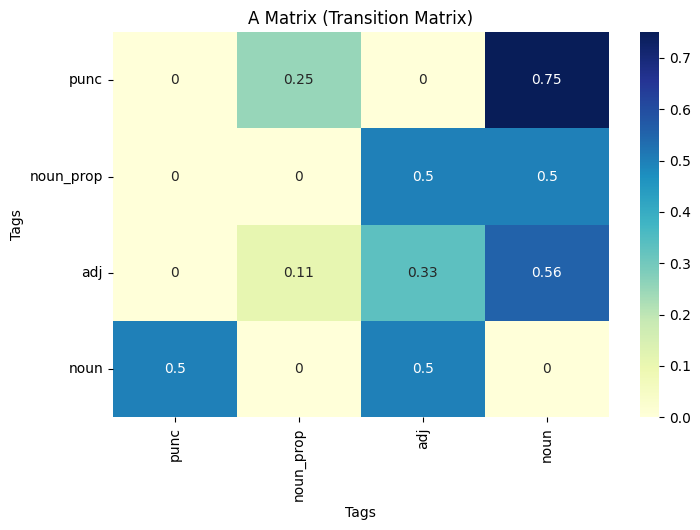

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(A, xticklabels=tag_set, yticklabels=tag_set, cmap="YlGnBu", cbar=True,annot=True)
plt.title("A Matrix (Transition Matrix)")
plt.xlabel("Tags")
plt.ylabel("Tags")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

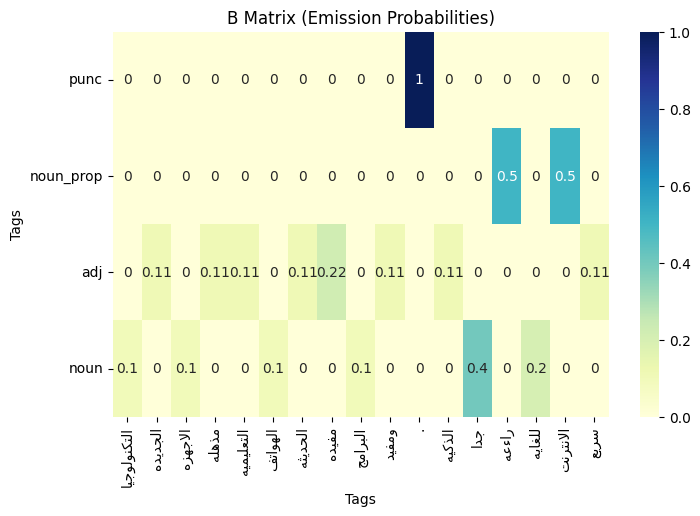

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(B, xticklabels=[get_display(arabic_reshaper.reshape(w)) for w in word_set], yticklabels=tag_set, cmap="YlGnBu", cbar=True,annot=True)
plt.title("B Matrix (Emission Probabilities)")
plt.xlabel("Tags")
plt.ylabel("Tags")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Show Transition states graph

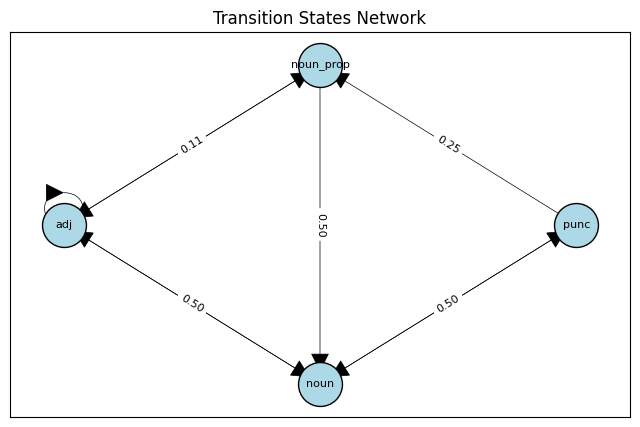

In [ ]:
transition_matrix = A
# Create a directed graph
G = nx.DiGraph()
# Add nodes with their tag names
for tag in tag_set:
    G.add_node(tag)
# Add edges with weights from the transition matrix
for i, from_tag in enumerate(tag_set):
    for j, to_tag in enumerate(tag_set):
        probability = transition_matrix[i, j]
        if probability > 0:  # Only add edges with non-zero probability
            G.add_edge(from_tag, to_tag, weight=probability)
# Set up the figure size
plt.figure(figsize=(8, 5))  # Increase the figure size
# Draw the graph
pos = nx.circular_layout(G)  # Position nodes using spring layout
edges = G.edges(data=True)
# Draw nodes with larger size
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue', edgecolors='black')
# Draw edges with increased width
nx.draw_networkx_edges(G, pos, width=0.5, arrowstyle='-|>', arrowsize=30)
# Draw edge labels with increased font size
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in edges}, font_size=8)
# Draw node labels with larger font size
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
plt.title("Transition States Network")
plt.show()


### Viterbi algorithm for Inference

In [ ]:
def viterbi(observations, pi, A, B):
    T = len(observations)
    N = pi.shape[0]

    dp = np.zeros((N, T))
    bp = np.zeros((N, T), dtype=int)

    dp[:, 0] = pi * B[:, observations[0]]

    for t in range(1, T):
        for s in range(N):
            dp[s, t] = np.max(dp[:, t-1] * A[:, s]) * B[s, observations[t]]
            bp[s, t] = np.argmax(dp[:, t-1] * A[:, s])

    best_path = np.zeros(T, dtype=int)
    best_path[T-1] = np.argmax(dp[:, T-1])
    for t in range(T-2, -1, -1):
        best_path[t] = bp[best_path[t+1], t+1]

    return best_path,dp,bp

### Let's define test sentences

In [ ]:
testSentences = [
    "الأجهزة الجديدة مذهلة جداً",
    "قالت محكمة العدل الدولية إن سياسة الاستيطان الإسرائيلية في الضفة الغربية تنتهك القانون الدولي.",
    "ويستغرق رئيس محكمة العدل الدولية نواف سلام، نحو ساعة لقراءة الرأي الكامل للجنة المكونة من 15 قاضيا من مختلف أنحاء العالم.",
    "ورفضت إسرائيل حضور الجلسات، مكتفية بمرافعة مكتوبة.",
 "وتختلف هذه القضية التي تنظر فيها محكمة العدل الدولية عن القضية التي رفعتها جنوب أفريقيا، تتهم فيها إسرائيل بارتكاب إبادة جماعية ضد الفلسطينيين في حربها على غزة.",
    "وأضاف أن الاحتلال الإسرائيلي الطويل والمتواصل لفلسطين يهدف إلى إلغاء فلسطين من الوجود، وإلى تدمير الفلسطينيين تدميراً شاملاً."
]

### Create tags for test sentences

In [ ]:
testTags=[tagger.tag(tokenizer.simple_word_tokenize(normalize_arabic(sent))) for sent in testSentences]

### Lets apply the same preprocessing and measure f1 score with true tags

In [ ]:
for i,(testSent,realTag) in enumerate(zip(testSentences[:1],testTags[:1])):
    observations = [word2idx[word] for word in tokenizer.simple_word_tokenize(normalize_arabic(testSent))]
    best_path,dpMatrix,bpMatrix = viterbi(observations, pi, A, B)
    best_tags = [idx2tag[idx] for idx in best_path]
    print(f"F1Score-Sent{i+1}::{f1_score([tag2idx[t] for t in realTag]  , best_path, average='macro')}")

F1Score-Sent1::1.0


### Draw Lattice for one of test sentneces

In [ ]:
def plot_lattice(observations, pi, A, B, sentence):
    T = len(observations)
    N = pi.shape[0]

    G = nx.DiGraph()
    pos = {}
    labels = {}

    dp = np.zeros((N, T))
    bp = np.zeros((N, T), dtype=int)

    dp[:, 0] = pi * B[:, observations[0]]

    for s in range(N):
        G.add_node(f"{idx2tag[s]}_0", pos=(0, s))
        pos[f"{idx2tag[s]}_0"] = (0, N-s)
        labels[f"{idx2tag[s]}_0"] = f"{idx2tag[s]}\n{dp[s, 0]:.2e}"

    for t in range(1, T):
        for s in range(N):
            dp[s, t] = np.max(dp[:, t-1] * A[:, s]) * B[s, observations[t]]
            bp[s, t] = np.argmax(dp[:, t-1] * A[:, s])
            for sp in range(N):
                if dp[sp, t-1] * A[sp, s] > 0:
                    G.add_edge(f"{idx2tag[sp]}_{t-1}", f"{idx2tag[s]}_{t}")

            G.add_node(f"{idx2tag[s]}_{t}", pos=(t, s))
            pos[f"{idx2tag[s]}_{t}"] = (t, N-s)
            labels[f"{idx2tag[s]}_{t}"] = f"{idx2tag[s]}\n{dp[s, t]:.2e}"

    best_path = np.zeros(T, dtype=int)
    best_path[T-1] = np.argmax(dp[:, T-1])

    for t in range(T-2, -1, -1):
        best_path[t] = bp[best_path[t+1], t+1]

    best_tags = [idx2tag[idx] for idx in best_path]

    path_edges = [(f"{best_tags[t]}_{t}", f"{best_tags[t+1]}_{t+1}") for t in range(T-1)]

    # Add tokens at the bottom
    for t in range(T):
        token_pos = (t, -1)
        G.add_node(f"{sentence[t]}_token", pos=token_pos)
        pos[f"{sentence[t]}_token"] = token_pos
        labels[f"{sentence[t]}_token"] = get_display(arabic_reshaper.reshape(sentence[t]))

    plt.figure(figsize=(8, 6))
    node_colors = ['lightblue' if '_token' not in node else 'lightgreen' for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=2000, node_color=node_colors, font_size=10)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)

    plt.title("HMM POS Tagging Lattice with Tokens and Viterbi Path")
    plt.show()

### Let's Show Lattice

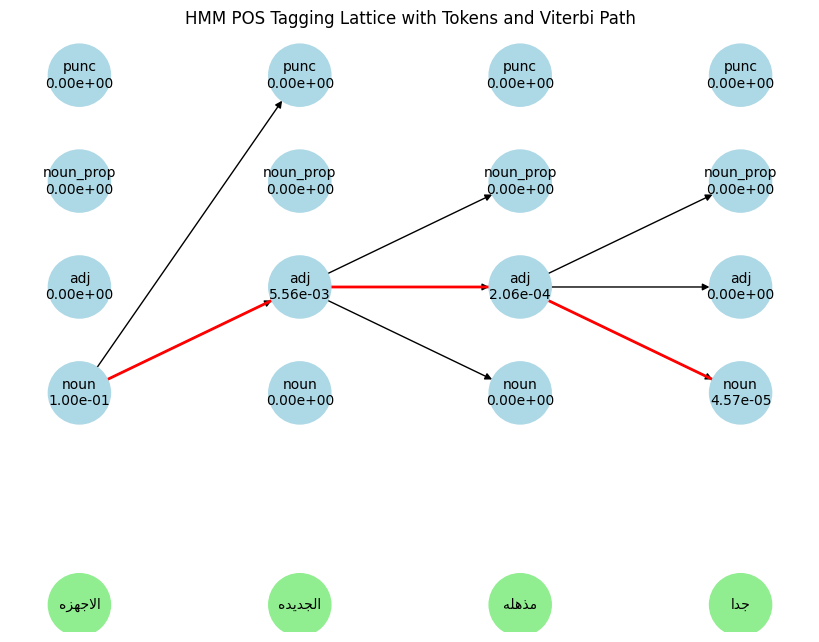

In [ ]:
observationsForTest=[word2idx[word] for word in tokenizer.simple_word_tokenize(normalize_arabic(testSentences[0]))]
plot_lattice(observationsForTest, pi, A, B, tokenizer.simple_word_tokenize(normalize_arabic(testSentences[0])))

### Show ***DP*** Matrix

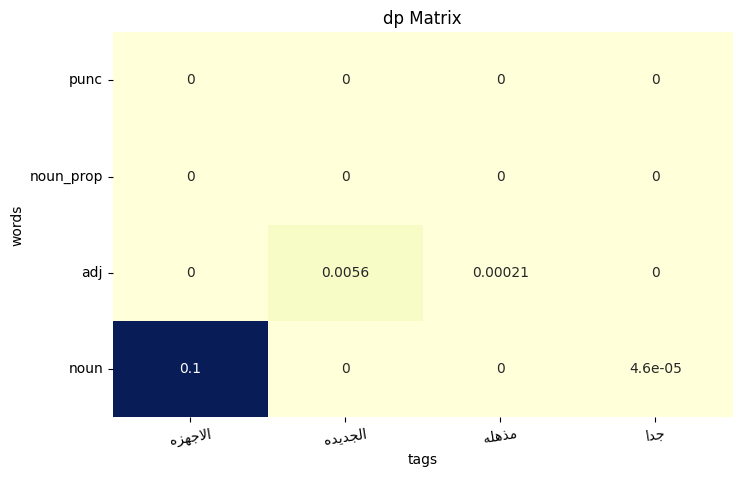

In [ ]:
best_path,dpMatrix,bpMatrix = viterbi(observationsForTest, pi, A, B)
plt.figure(figsize=(8,5))
sns.heatmap(dpMatrix, xticklabels=[get_display(arabic_reshaper.reshape(idx2word[w])) for w in observationsForTest], yticklabels=tag_set, cmap="YlGnBu", cbar=False,annot=True)
plt.title("dp Matrix")
plt.xlabel("tags")
plt.ylabel("words")
plt.xticks(rotation=9)
plt.yticks(rotation=0)
plt.show()

### show ***BP*** Matrix

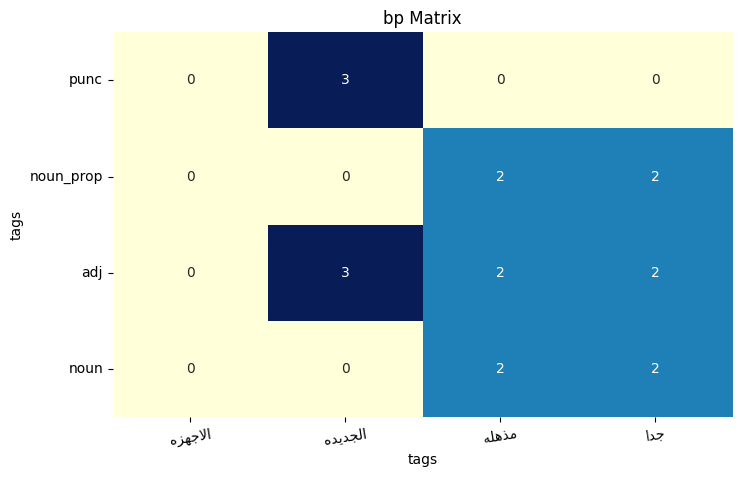

In [ ]:
best_path,dpMatrix,bpMatrix = viterbi(observationsForTest, pi, A, B)
plt.figure(figsize=(8,5))
sns.heatmap(bpMatrix, xticklabels=[get_display(arabic_reshaper.reshape(idx2word[w])) for w in observationsForTest], yticklabels=tag_set, cmap="YlGnBu", cbar=False,annot=True)
plt.title("bp Matrix")
plt.xlabel("tags")
plt.ylabel("tags")
plt.xticks(rotation=9)
plt.yticks(rotation=0)
plt.show()

### Let's Train our own POS model

## Methodology

1. **Data Collection:** Utilizing the Beautiful Soup library, we scrape comments from social media platforms such as Twitter and Facebook belonging to Egyptian companies.
   
2. **Preprocessing:** The dataset undergoes rigorous preprocessing to standardize text by normalized text,handling emojis, applying lemmatization.

3. **Generate Pos Tags:** Using camel tools arabic model to assign pos tags for reviews.

3. **Model Selection and Training:** Training using aravec embeedings (BiLstm,Lstm,GRU,BiGRU).
   
4. **Model Evaluation:** F1-score are employed to assess the performance of each model.

### Read Data

In [ ]:
dataFrame=pd.read_csv("/content/CompanyReviews.csv")
dataFrame.drop(columns=["Unnamed: 0"])

,review_description,rating,company
0,رائع,1,talbat
1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat
...,...,...,...
40041,تجربه جيده بس ينقصها عدم اهتمام خدمة العملاء ب...,0,swvl
40042,انا ساكنة بمنطقة الكينج ولا توجد عربيات قبل ال...,-1,swvl
40043,جيد ولكن لماذا لا توجد خطوط كثيره من المريوطيه...,0,swvl
40044,جيدا جدا ...ولكن الاسعار عاليه جدا\n,0,swvl


## Clean Data

### Remove Duplicates

In [ ]:
dataFrame.review_description.duplicated().sum()

1042

In [ ]:
dataFrame.drop(dataFrame[dataFrame.review_description.duplicated() == True].index, axis = 0, inplace = True)

In [ ]:
dataFrame.review_description.duplicated().sum()

0

### Remove Null

In [ ]:
dataFrame.review_description.duplicated().isnull().sum()

0

### Let's Remove any small examples

In [ ]:
dataFrame["review_description"]=dataFrame["review_description"].astype(str)

In [ ]:
dataFrame["review_description_length"]=dataFrame["review_description"].progress_apply(lambda x:len(tokenizer.simple_word_tokenize(x)))

  0%|          | 0/39004 [00:00<?, ?it/s]

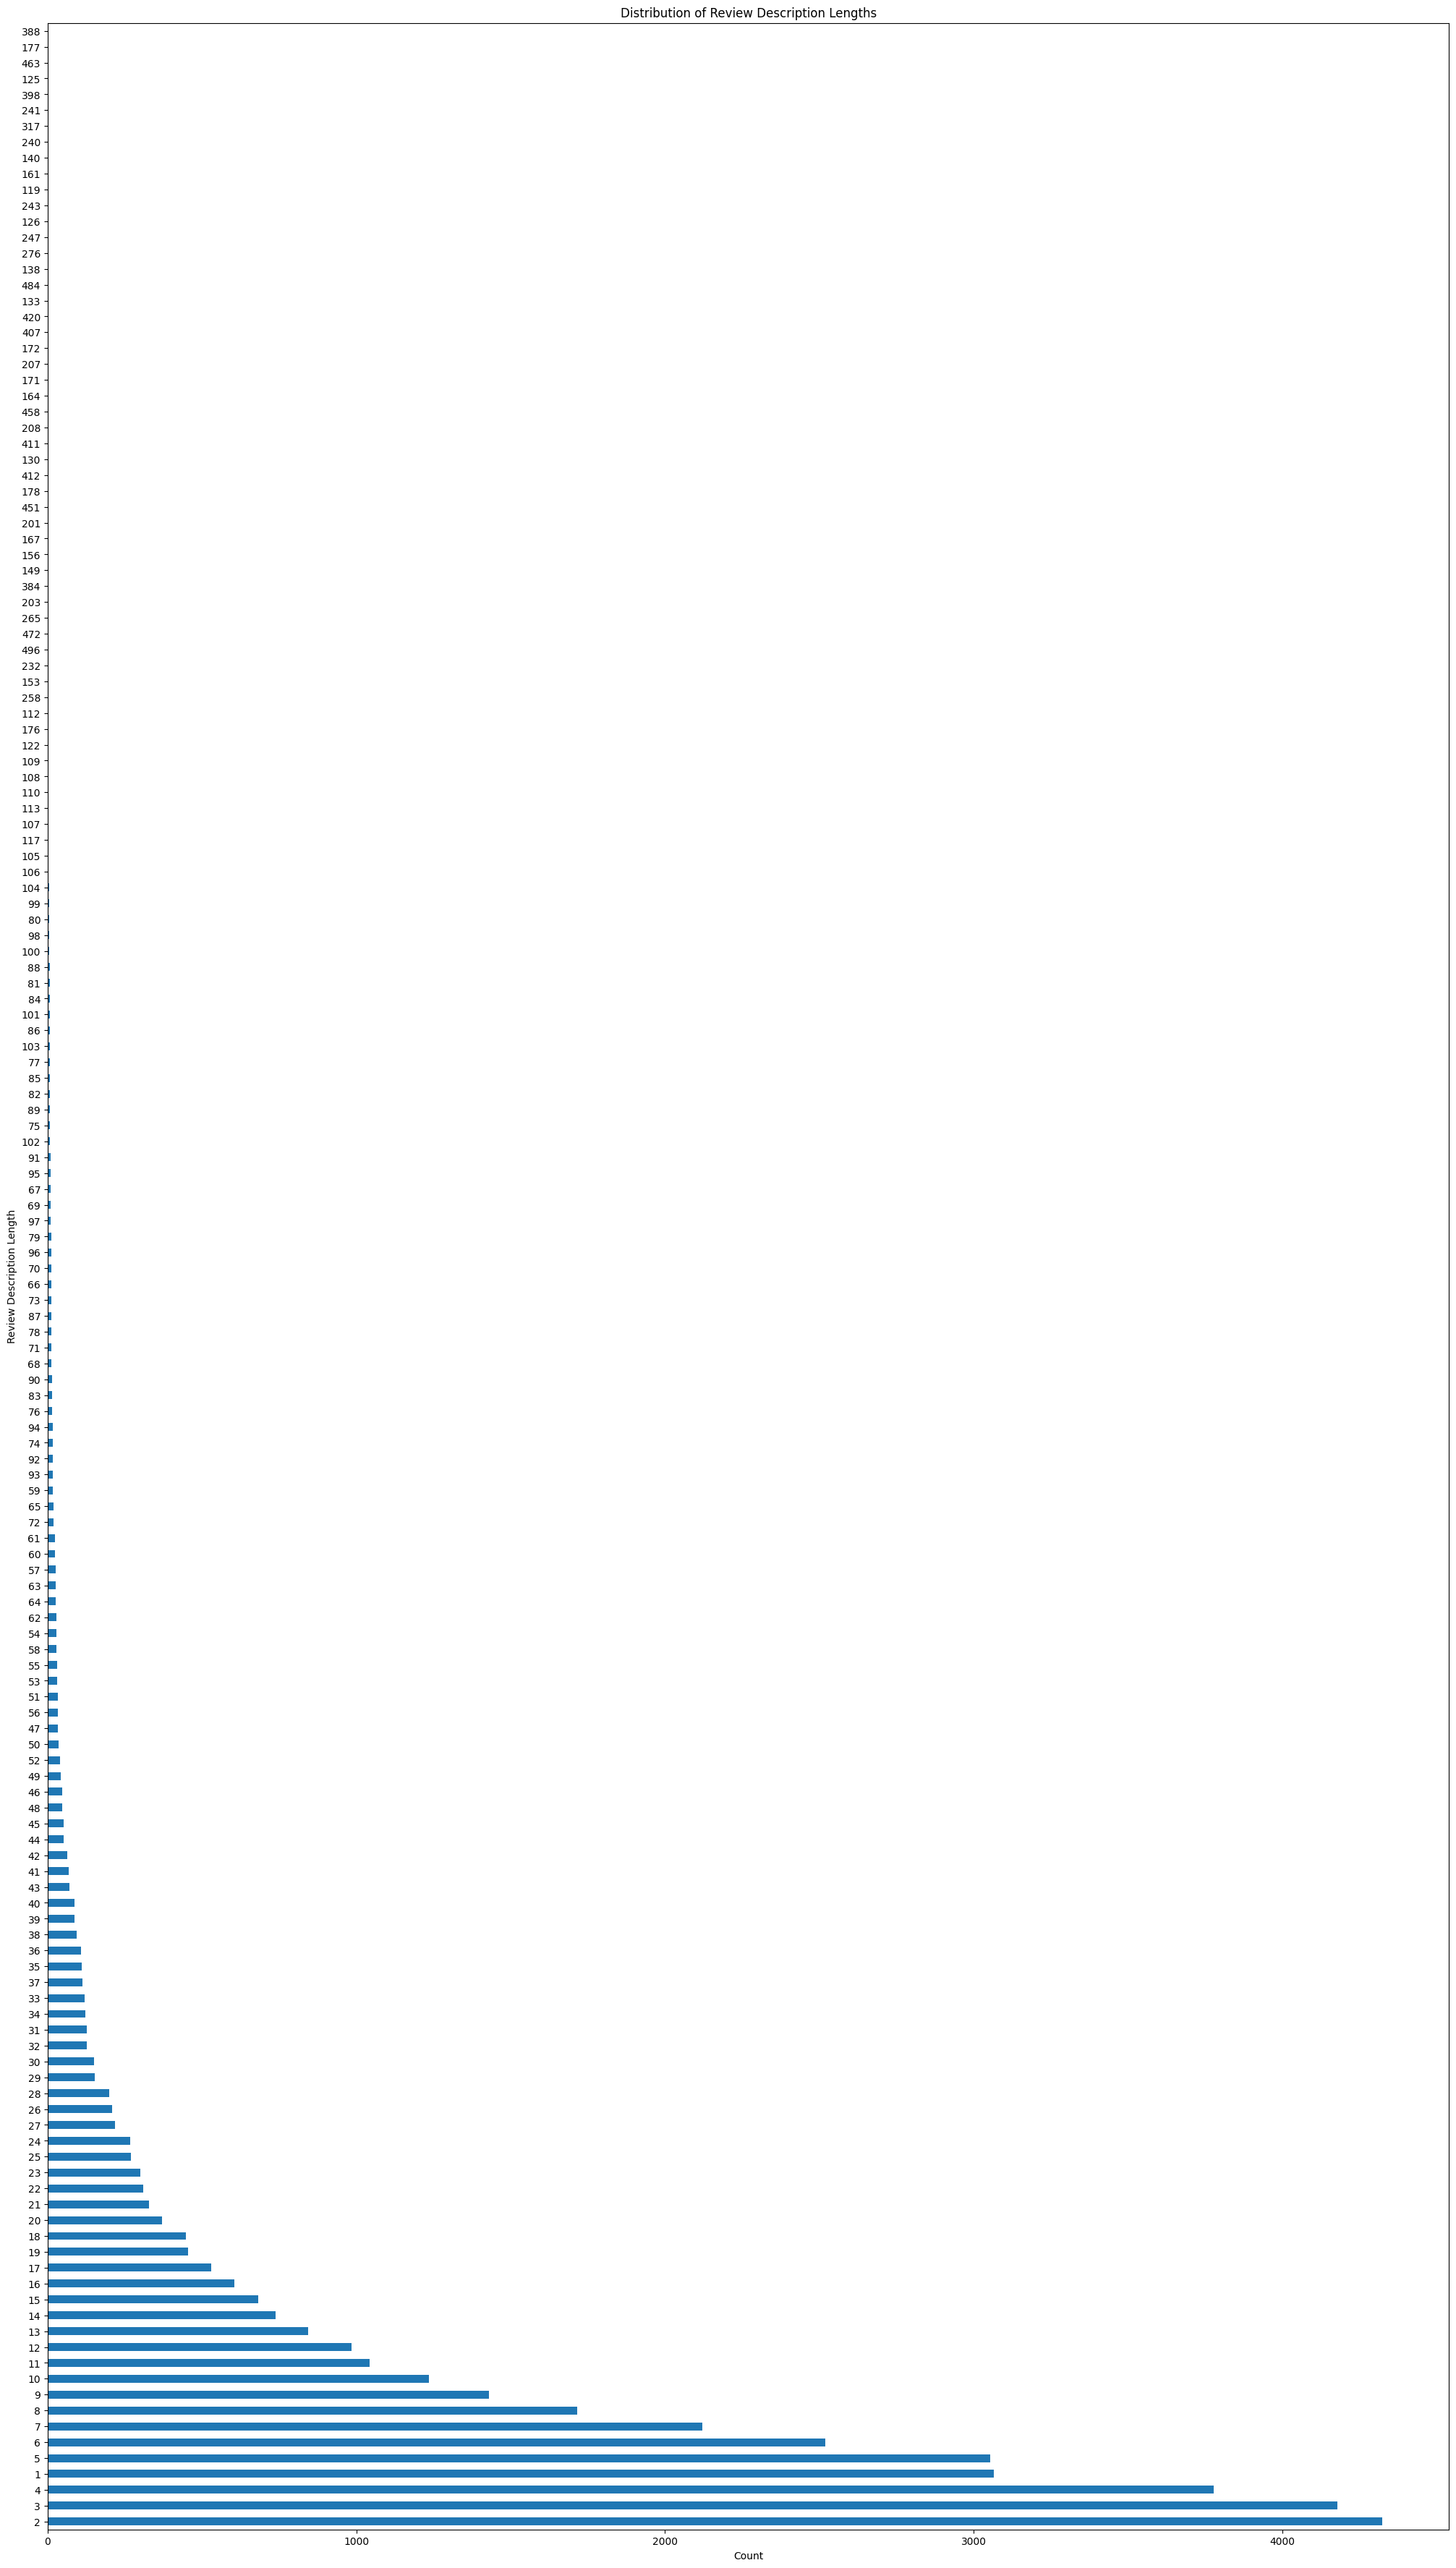

In [ ]:
length_counts = dataFrame["review_description_length"].value_counts()
# Plotting the value counts
plt.figure(figsize=(25, 45))
length_counts.plot(kind='barh')  # Use horizontal bar plot
plt.title('Distribution of Review Description Lengths')
plt.xlabel('Count')
plt.ylabel('Review Description Length')
plt.xticks(rotation=0)
plt.show()

### Conclusion will remove sentence greater than 60 tokens since not need and will complex our arch

In [ ]:
dataFrame=dataFrame[dataFrame["review_description_length"]<=60]

## Preprocessing

### Apply Normaliztion

In [ ]:
dataFrame["review_description"]=dataFrame["review_description"].astype(str)
dataFrame["review_description"]=dataFrame["review_description"].progress_apply(lambda x:normalize_arabic(x))

  0%|          | 0/38417 [00:00<?, ?it/s]

### Remove any emojies in text

In [ ]:
dataFrame.loc[20346,:]

Unnamed: 0                                                20346
review_description           والله من جد افخم تطبيق للمطاعم 👉🏼❤
rating                                                        1
company                                                  talbat
review_description_length                                     8
Name: 20346, dtype: object

In [ ]:
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')


In [ ]:
remove_emojis(dataFrame.loc[20346,:]["review_description"])

'والله من جد افخم تطبيق للمطاعم '

### Apply on hole data

In [ ]:
dataFrame["review_description"]=dataFrame["review_description"].progress_apply(remove_emojis)

  0%|          | 0/38417 [00:00<?, ?it/s]

In [ ]:
dataFrame.loc[20346,:]["review_description"]

'والله من جد افخم تطبيق للمطاعم '

### Let's check we need to apply stemming or lemmitizing for our data or not

In [ ]:
tagger = DefaultTagger(mle, 'pos')

In [ ]:
from snowballstemmer import stemmer
lemmer = qalsadi.lemmatizer.Lemmatizer()
ar_stemmer = stemmer("arabic")

In [ ]:
nonLemmatizedTokens=tokenizer.simple_word_tokenize(dataFrame["review_description"].iloc[11])
stemTokenss=[ar_stemmer.stemWord(tok) for tok in nonLemmatizedTokens]
lemmatizedTokens=lemmer.lemmatize_text(dataFrame["review_description"].iloc[11])
nonLemtizedtokensTags=tagger.tag(nonLemmatizedTokens)
lemtizedTokensTags=tagger.tag(lemmatizedTokens)
stemmtokensTags=tagger.tag(stemTokenss)


In [ ]:
pd.DataFrame({
    "nonLemmatizeToken":nonLemmatizedTokens,
    "LemmatizeToken":lemmatizedTokens,
    "nonLemmatizeTokenTag":nonLemtizedtokensTags,
    "LemmatizeTokenTag":lemtizedTokensTags,
     "correctLemm":['✔' if nontag == lemtag else '✘' for nontag, lemtag in zip(nonLemtizedtokensTags, lemtizedTokensTags)],
    "stemToken":stemTokenss,
    "stemTokenTag":stemmtokensTags,
         "correctstemm":['✔' if nontag == stemtag else '✘' for nontag, stemtag in zip(nonLemtizedtokensTags, stemmtokensTags)]

})

,nonLemmatizeToken,LemmatizeToken,nonLemmatizeTokenTag,LemmatizeTokenTag,correctLemm,stemToken,stemTokenTag,correctstemm
0,اسعارهم,اسعارهم,noun,noun,✔,اسعار,noun,✔
1,اغلا,اغلا,verb,verb,✔,اغل,verb,✔
2,من,من,prep,prep,✔,من,prep,✔
3,المحلات,محل,noun,noun,✔,محل,noun,✔
4,ب,ب,abbrev,abbrev,✔,ب,abbrev,✔
5,كثير,كثير,noun,noun,✔,كثير,noun,✔
6,و,و,conj,conj,✔,و,conj,✔
7,بحطولك,بحطولك,noun_prop,noun_prop,✔,حطول,noun_prop,✔
8,توصيل,توصيل,noun,noun,✔,توصيل,noun,✔
9,مجاني,مجان,adj,noun,✘,مجا,verb,✘


***Conclusion***
### we will not use stemmer or lemmitzer for arabic pos since it will effectt the words which will change it's tag whick is not true

### Remove Tashkeel

In [ ]:
dataFrame["review_description"]=dataFrame["review_description"].progress_apply(lambda x:dediac_ar(x))

  0%|          | 0/38417 [00:00<?, ?it/s]

#### Let's Create POS Tags for our sentences

In [ ]:
posTags=[]
tokenizedTokens=[]
for rev in tqdm(dataFrame["review_description"].to_list()):
    tokens=tokenizer.simple_word_tokenize(rev)
    tokenizedTokens.append(tokens)
    posTags.append(tagger.tag(tokens))

  0%|          | 0/38417 [00:00<?, ?it/s]

In [ ]:
tagsList=list(set([tag for taglist in posTags for tag in taglist]))

In [ ]:
tagsCounts={tag:0 for tag in tagsList}
for taglist in posTags:
    for tag in taglist:
        tagsCounts[tag]+=1
tagsCounts

{'verb': 47374,
 'part_neg': 4651,
 'interj': 165,
 'pron': 3517,
 'part_voc': 417,
 'part_focus': 125,
 'pron_rel': 3612,
 'adv_interrog': 217,
 'part_verb': 127,
 'verb_pseudo': 303,
 'part_det': 87,
 'part_interrog': 280,
 'adj': 24743,
 'part': 325,
 'punc': 15226,
 'abbrev': 2213,
 'conj_sub': 3102,
 'digit': 3836,
 'noun_prop': 49716,
 'adv': 882,
 'pron_interrog': 52,
 'part_fut': 64,
 'noun': 142057,
 'prep': 24234,
 'pron_dem': 1323,
 'foreign': 5185,
 'noun_quant': 1014,
 'adv_rel': 264,
 'conj': 7630}

In [ ]:
tags2idx={tag:idx for idx,tag in enumerate(tagsList)}
idx2tags={idx:tag for idx,tag in enumerate(tagsList)}

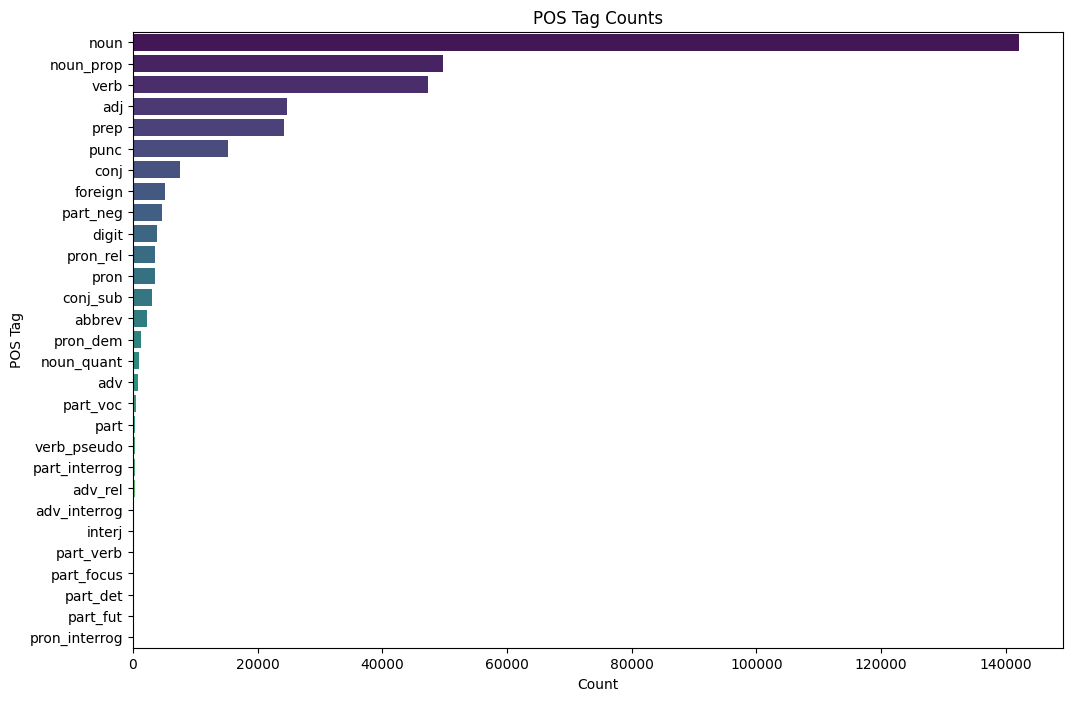

In [ ]:
tags_df = pd.DataFrame(list(tagsCounts.items()), columns=['POS', 'Count'])
tags_df = tags_df.sort_values(by='Count', ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='Count', y='POS', data=tags_df, palette='viridis')
plt.xlabel('Count')
plt.ylabel('POS Tag')
plt.title('POS Tag Counts')
plt.show()

In [ ]:
class POSDataset(Dataset):
    def __init__(self,tokens,tags,embedding_model,tags2idx,max_len=60, device='cuda'):
        self.sentences=tokens

        self.embedding_model = embedding_model
        self.max_len = max_len
        self.device = device
        self.pos_tags = tags
        self.tag2idx=tags2idx
        self.tokenized_sentences = self._tokenize_and_pad()
        self.encoded_tags = self._encode_tags()


    def _tokenize_and_pad(self):
        tokenized_sentences = []

        for i in range(0, len(self.sentences), 1):  # Use batch size of 1 to keep it simple
            batch_sentences = self.sentences[i:i + 1]

            batch_tokenized = [
                [self.embedding_model.wv.key_to_index[word] if word in self.embedding_model.wv.key_to_index else 0 for word in sent]
                for sent in batch_sentences
            ]

            batch_padded = torch.tensor([
                sent + [0] * (self.max_len - len(sent)) for sent in batch_tokenized
            ], device=self.device)

            tokenized_sentences.append(batch_padded)

        tokenized_sentences = torch.cat(tokenized_sentences, dim=0)
        return tokenized_sentences

    def _encode_tags(self):
        encoded_tags = [[self.tag2idx[tag] for tag in tags] for tags in self.pos_tags]

        padded_tags = [tags + [self.tag2idx["punc"]] * (self.max_len - len(tags)) for tags in encoded_tags]
        return torch.tensor(padded_tags, device=self.device)

    def __len__(self):
        return len(self.tokenized_sentences)

    def __getitem__(self, idx):
        return self.tokenized_sentences[idx], self.encoded_tags[idx]

## Instal Embeddings

In [ ]:
!curl -o full_grams_cbow_300_twitter.zip "https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip"


In [6]:
!unzip full_grams_cbow_300_twitter.zip

Archive:  full_grams_cbow_300_twitter.zip
  inflating: full_grams_cbow_300_twitter.mdl  
  inflating: full_grams_cbow_300_twitter.mdl.trainables.syn1neg.npy  
  inflating: full_grams_cbow_300_twitter.mdl.wv.vectors.npy  


### Load Embeddings

In [7]:
embedding_model = gensim.models.Word2Vec.load('full_grams_cbow_300_twitter.mdl')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Create POS Datset

In [ ]:
dataset=POSDataset(tokenizedTokens,posTags,embedding_model,tags2idx,max_len=60)

### Split DataSet

In [ ]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
batch_size=8
# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(f"TrainSize:{len(train_dataset)},ValidationSize:{len(val_dataset)},TestSize:{len(test_dataset)}")

TrainSize:30733,ValidationSize:5762,TestSize:1922


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_model, output_size, hidden_size, embedding_dim, device,bidirectional=True):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_model.wv.vectors))
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)  # *2 for bidirectional
        self.device = device
        self.dropout=nn.Dropout(0.2)
    def forward(self, x):
        x = x.to(self.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(self.dropout(lstm_out))
        return out

### Let's Train LSTM Model At first

In [ ]:
# Hyperparameters
output_size = len(tagsList)
hidden_size = 64
embedding_dim = embedding_model.vector_size
batch_size = 8
epochs = 25
accumulation_steps = 4
bidirection=False

In [ ]:
def TrainingLoop(model,epochs,train_loader,val_loader):
    # Training loop with validation and F1 score
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        all_train_preds = []
        all_train_labels = []
        optimizer.zero_grad()

        for i, (batch_sentences, batch_tags) in enumerate(train_loader):
            outputs = model(batch_sentences)
            loss = criterion(outputs.permute(0, 2, 1), batch_tags)
            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=2)
            all_train_preds.extend(preds.cpu().numpy().flatten())
            all_train_labels.extend(batch_tags.cpu().numpy().flatten())

        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro', zero_division=0)
        print(f'Epoch [{epoch+1}/{epochs}]========================================\nLoss: {running_loss / len(train_loader)}, Training F1 Score: {train_f1}')

        # Validation loop
        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for batch_sentences, batch_tags in val_loader:
                outputs = model(batch_sentences)
                loss = criterion(outputs.permute(0, 2, 1), batch_tags)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=2)
                all_val_preds.extend(preds.cpu().numpy().flatten())
                all_val_labels.extend(batch_tags.cpu().numpy().flatten())

        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
        print(f'Validation Loss: {val_loss / len(val_loader)}, Validation F1 Score: {val_f1}')
    return model

In [ ]:
def testLooping(model,test_loader):
    model.eval()
    test_loss = 0.0
    all_test_preds = []
    all_test_labels = []
    startTime=time.time()
    with torch.no_grad():
        for batch_sentences, batch_tags in test_loader:
            outputs = model(batch_sentences)
            loss = criterion(outputs.permute(0, 2, 1), batch_tags)
            test_loss += loss.item()
            preds = torch.argmax(outputs, dim=2)
            all_test_preds.extend(preds.cpu().numpy().flatten())
            all_test_labels.extend(batch_tags.cpu().numpy().flatten())
    endTime=time.time()
    InferenceTime=endTime-startTime

    ##ploting
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
    # Manually plot the confusion matrix
    plt.figure(figsize=(20, 15))  # Adjust the figsize as needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=tagsList, yticklabels=tagsList)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for POS Tagging')
    plt.show()


    test_f1 = f1_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
    print(f'Test Loss: {test_loss / len(test_loader)}\n Test F1 Score: {test_f1}\n Inference Time:{InferenceTime} secs')
    return InferenceTime,test_f1

In [ ]:
LstmModel = LSTMModel(embedding_model, output_size, hidden_size, embedding_dim, device,bidirection).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(LstmModel.parameters(), lr=0.001)

In [ ]:
LstmModel=TrainingLoop(LstmModel,epochs,train_loader,val_loader)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25]========================================
Loss: 0.04633319788970701, Training F1 Score: 0.321818357846836
Validation Loss: 0.07208341738304715, Validation F1 Score: 0.4969191856985423
Epoch [2/25]========================================
Loss: 0.016828487886885304, Training F1 Score: 0.6119812876608028
Validation Loss: 0.053948164012040244, Validation F1 Score: 0.7122552156172198
Epoch [3/25]========================================
Loss: 0.013534816172848302, Training F1 Score: 0.7278700548414713
Validation Loss: 0.04565971473363666, Validation F1 Score: 0.8025430570848474
Epoch [4/25]========================================
Loss: 0.011790240722779793, Training F1 Score: 0.8323791411146526
Validation Loss: 0.0415199260833194, Validation F1 Score: 0.8755668381202998
Epoch [5/25]========================================
Loss: 0.010790965306649702, Training F1 Score: 0.87845431744853
Validation Loss: 0.03936815369633981, Validation F1 Score: 0.8921455610737006
Epoch [6/25]=======

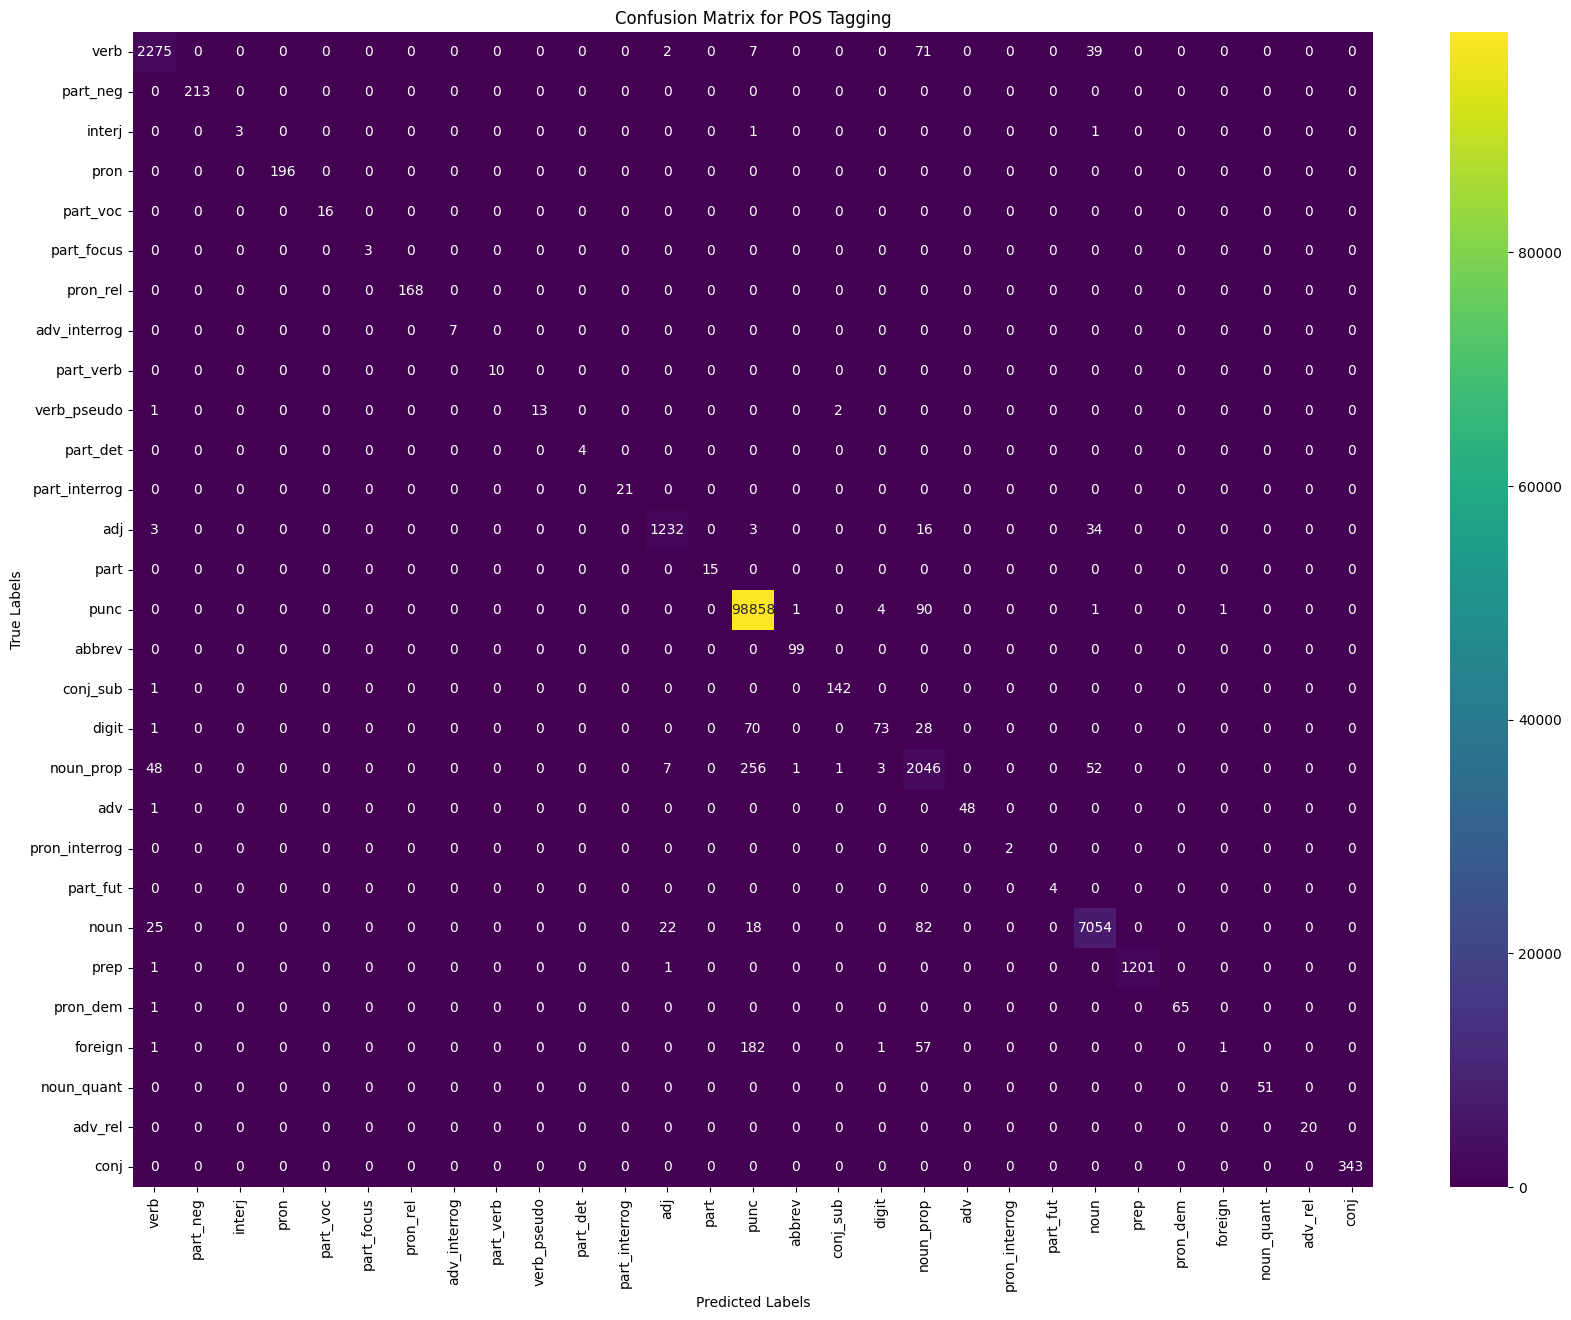

Test Loss: 0.03937708934444424
 Test F1 Score: 0.9290245130650585
 Inference Time:0.2513561248779297 secs


In [ ]:
Lstm_InferenceTime,test_f1_Lstm=testLooping(LstmModel,test_loader)

## Let's Train BI-LSTM model for measure diffrence between them

In [ ]:
bidirection=True
BiLstmModel = LSTMModel(embedding_model, output_size, hidden_size, embedding_dim, device,bidirection).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(BiLstmModel.parameters(), lr=0.001)

In [ ]:
BiLstmModel

LSTMModel(
  (embedding): Embedding(1476715, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=29, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
BiLstmModel=TrainingLoop(BiLstmModel,epochs,train_loader,val_loader)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25]========================================
Loss: 0.0331220091264215, Training F1 Score: 0.47240643608022687
Validation Loss: 0.05299297617502955, Validation F1 Score: 0.6838642786667657
Epoch [2/25]========================================
Loss: 0.012588276172425009, Training F1 Score: 0.7764175429562074
Validation Loss: 0.04047996268753639, Validation F1 Score: 0.8401101871371544
Epoch [3/25]========================================
Loss: 0.010190974433305756, Training F1 Score: 0.8820993376779865
Validation Loss: 0.03552269968481918, Validation F1 Score: 0.8962230332734048
Epoch [4/25]========================================
Loss: 0.008973746563074383, Training F1 Score: 0.9235712451705543
Validation Loss: 0.0326354122092888, Validation F1 Score: 0.9292732985888913
Epoch [5/25]========================================
Loss: 0.00810434898365927, Training F1 Score: 0.9404506518183652
Validation Loss: 0.031157052037519263, Validation F1 Score: 0.941873287316068
Epoch [6/25]======

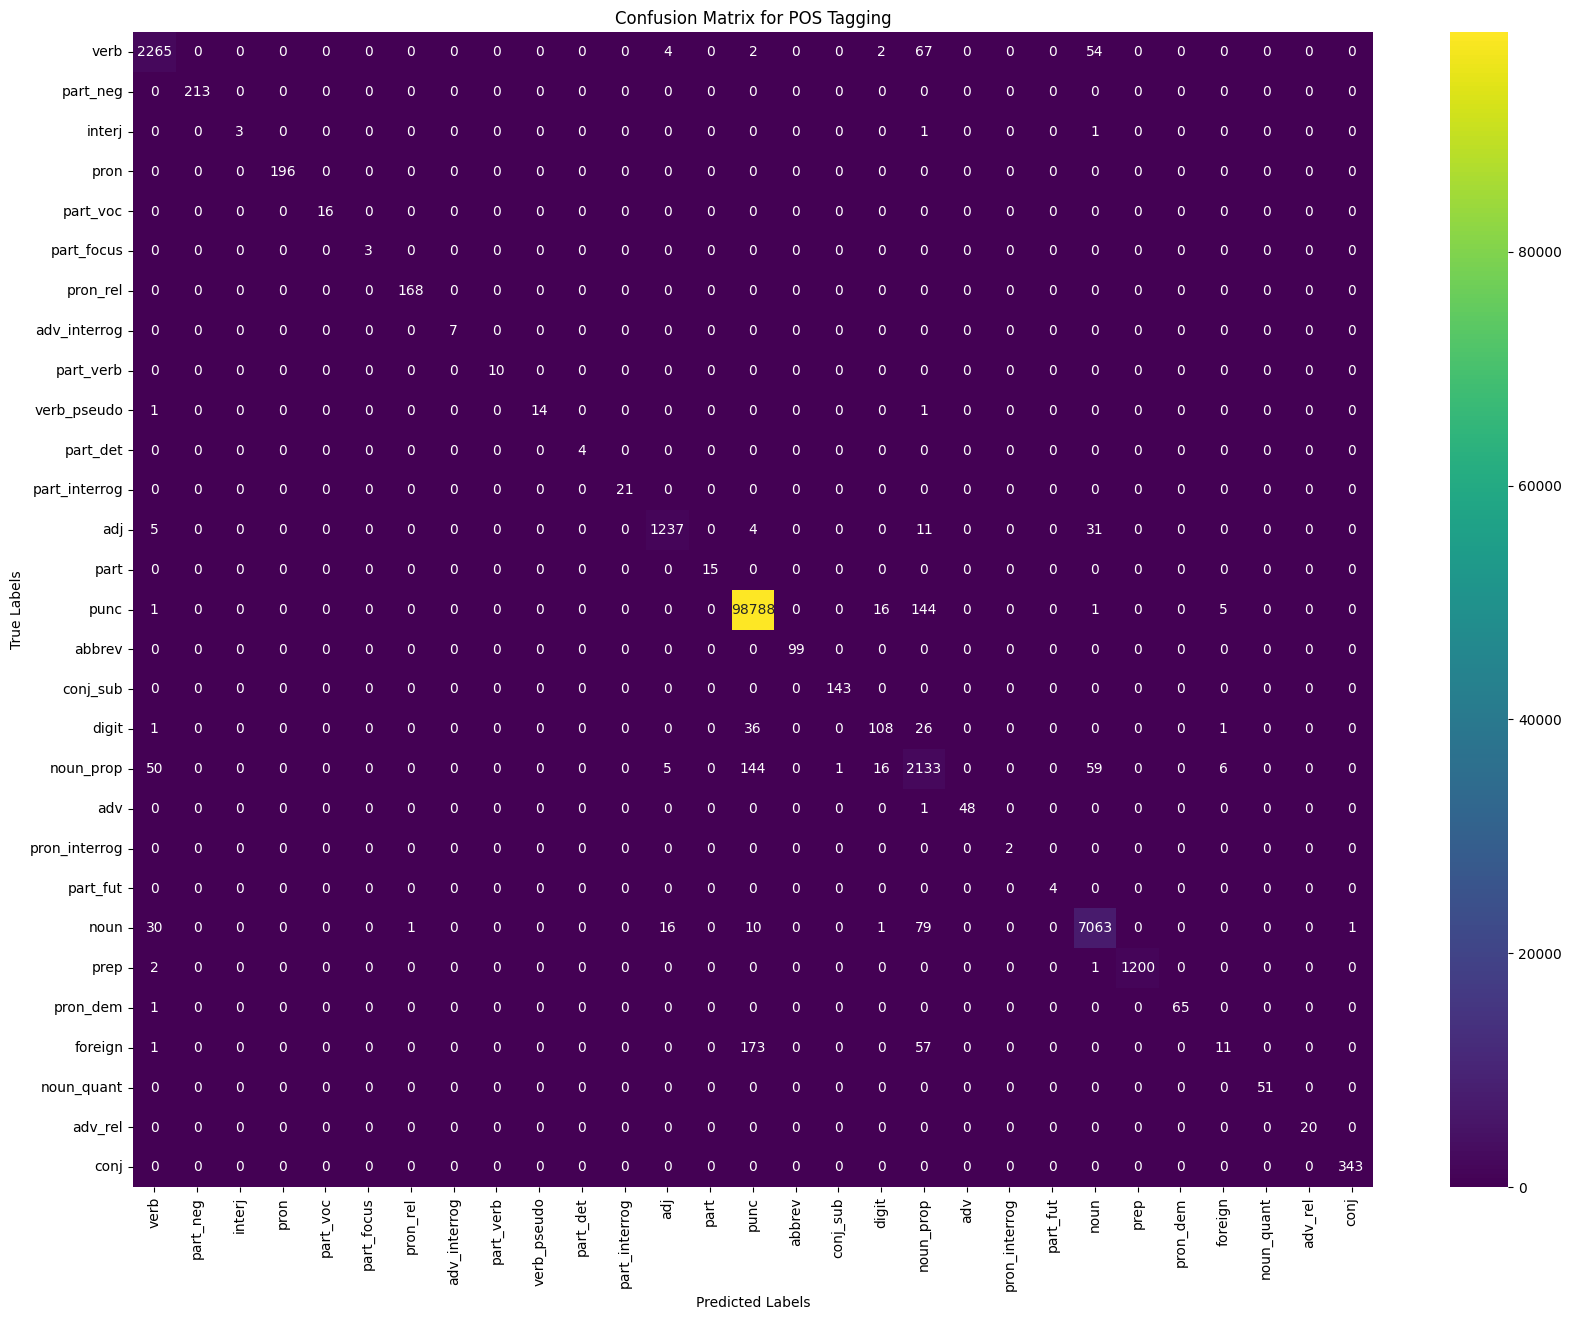

Test Loss: 0.038979300021733006
 Test F1 Score: 0.9376130428817976
 Inference Time:0.26417040824890137 secs


In [ ]:
BILstm_InferenceTime,test_f1_BILstm=testLooping(BiLstmModel,test_loader)

## Train GRU Model

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, embedding_model, output_size, hidden_size, embedding_dim, device,bidirectional=True):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_model.wv.vectors))
        self.GRU = nn.GRU(embedding_dim, hidden_size, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)  # *2 for bidirectional
        self.device = device
        self.dropout=nn.Dropout(0.2)
    def forward(self, x):
        x = x.to(self.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.GRU(embedded)
        out = self.fc(self.dropout(lstm_out))
        return out

In [ ]:
bidirection=False
GruModel = GRUModel(embedding_model, output_size, hidden_size, embedding_dim, device,bidirection).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(GruModel.parameters(), lr=0.001)

In [ ]:
GruModel=TrainingLoop(GruModel,epochs,train_loader,val_loader)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25]========================================
Loss: 0.043507403977465456, Training F1 Score: 0.3570808445394659
Validation Loss: 0.07233268197434703, Validation F1 Score: 0.5725961547356073
Epoch [2/25]========================================
Loss: 0.016997469823702274, Training F1 Score: 0.6676528141600232
Validation Loss: 0.05352541113249058, Validation F1 Score: 0.7300253089518794
Epoch [3/25]========================================
Loss: 0.013983978686686013, Training F1 Score: 0.7684859281837183
Validation Loss: 0.04680847338867088, Validation F1 Score: 0.8302250356782498
Epoch [4/25]========================================
Loss: 0.012474625923657254, Training F1 Score: 0.8508222498407304
Validation Loss: 0.043187482651302414, Validation F1 Score: 0.8634266302654043
Epoch [5/25]========================================
Loss: 0.011584649680630546, Training F1 Score: 0.8868029365068588
Validation Loss: 0.04133438904435166, Validation F1 Score: 0.9121505890000389
Epoch [6/25]==

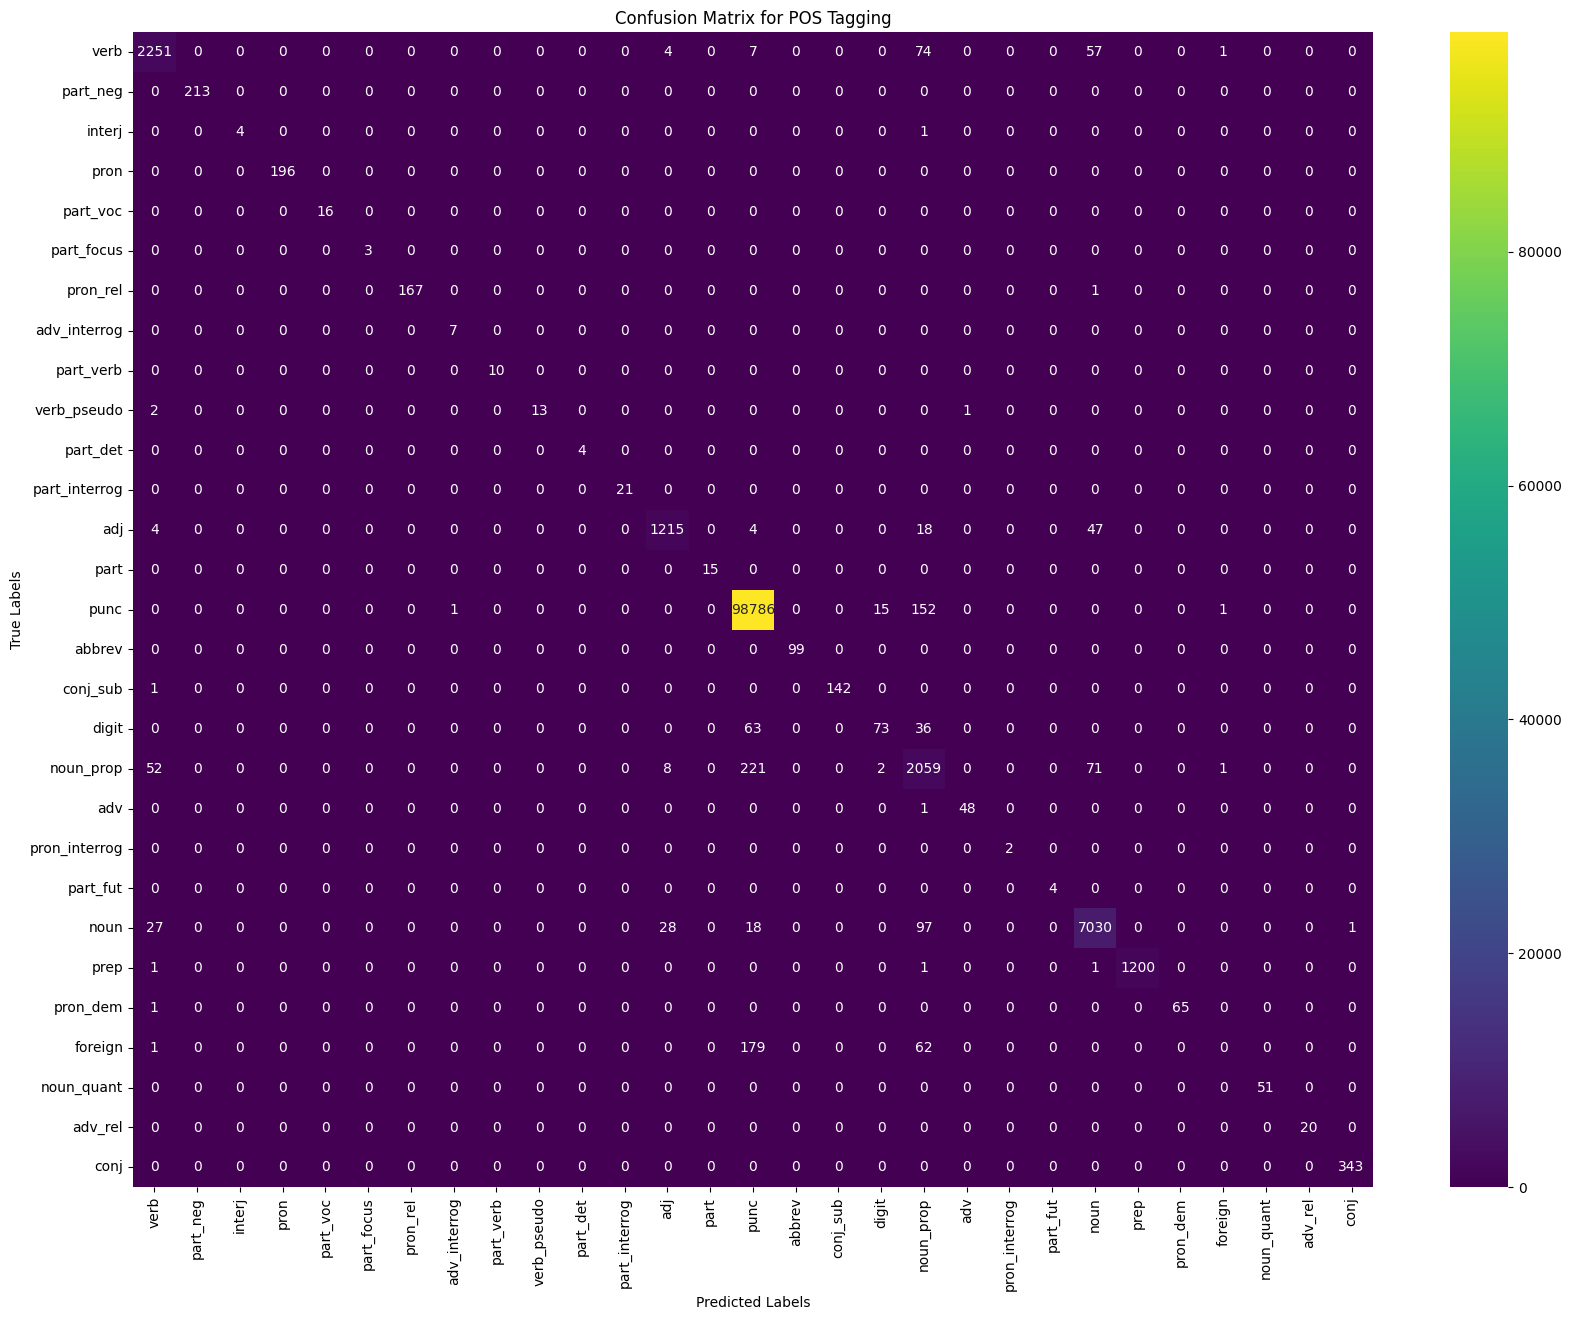

Test Loss: 0.04118473727557483
 Test F1 Score: 0.9295068604914273
 Inference Time:0.2543299198150635 secs


In [ ]:
gru_InferenceTime,test_f1_gru=testLooping(GruModel,test_loader)

### Try BI-GRU

In [ ]:
bidirection=True
BiGruModel = GRUModel(embedding_model, output_size, hidden_size, embedding_dim, device,bidirection).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(BiGruModel.parameters(), lr=0.001)

In [ ]:
BiGruModel=TrainingLoop(BiGruModel,epochs,train_loader,val_loader)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25]========================================
Loss: 0.029514293643119437, Training F1 Score: 0.49505625394083713
Validation Loss: 0.05388014697845658, Validation F1 Score: 0.7029257701032657
Epoch [2/25]========================================
Loss: 0.012684923384196446, Training F1 Score: 0.8306213249302558
Validation Loss: 0.042880723924581456, Validation F1 Score: 0.8784912200581732
Epoch [3/25]========================================
Loss: 0.010496420450052871, Training F1 Score: 0.9045395083794294
Validation Loss: 0.0388979833545977, Validation F1 Score: 0.9403281403212198
Epoch [4/25]========================================
Loss: 0.009264497891525877, Training F1 Score: 0.9384481309954659
Validation Loss: 0.035090685987408464, Validation F1 Score: 0.9392170709961628
Epoch [5/25]========================================
Loss: 0.008509094066514927, Training F1 Score: 0.9441062690099332
Validation Loss: 0.03292246833191758, Validation F1 Score: 0.9422499033996814
Epoch [6/25]=

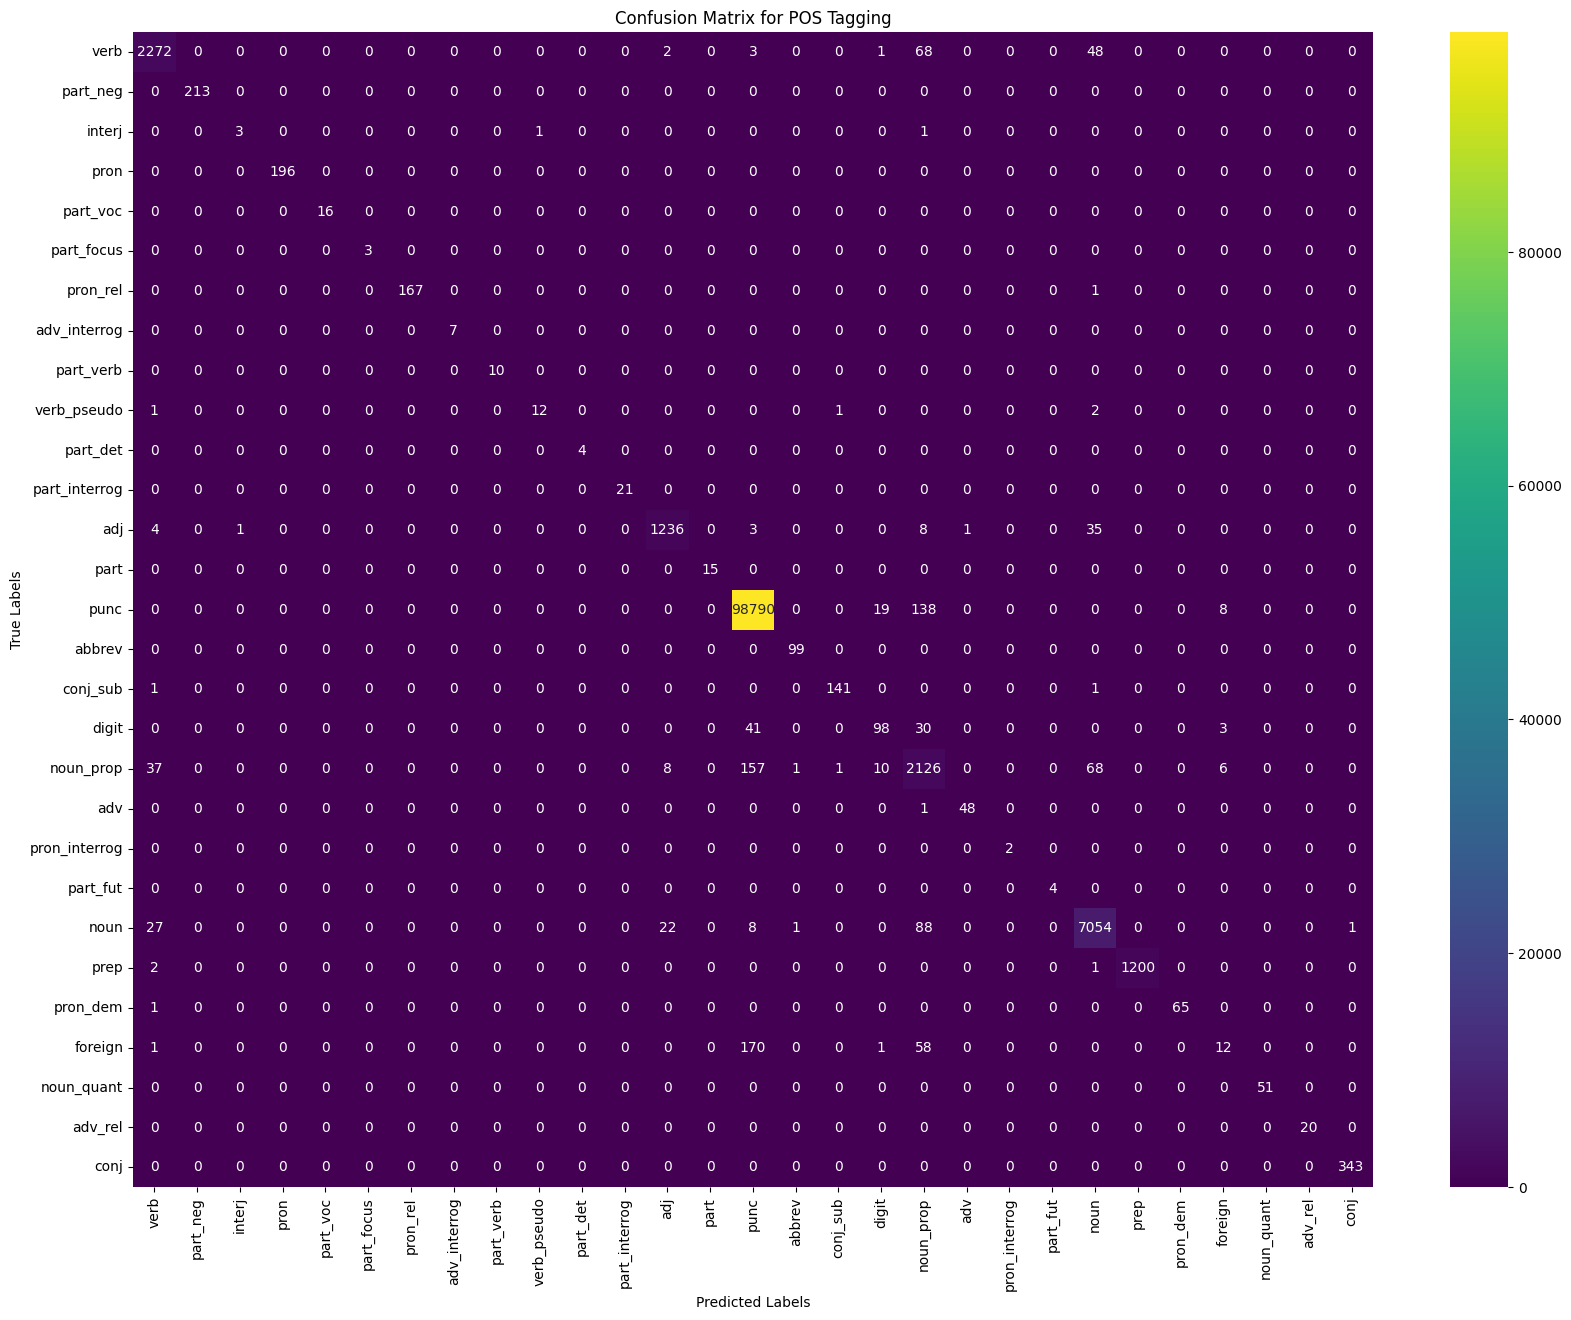

Test Loss: 0.039662711761159535
 Test F1 Score: 0.9289787601280428
 Inference Time:0.2591841220855713 secs


In [ ]:
bigru_InferenceTime,test_f1_bigru=testLooping(BiGruModel,test_loader)

In [ ]:
pd.DataFrame({
    "modelName":["LSTM","BI-LSTM","GRU","BI-GRU"],
    "Test-F1Score":[test_f1_Lstm,test_f1_BILstm,test_f1_gru,test_f1_bigru],
    "InfernceTime(secs)":[Lstm_InferenceTime,BILstm_InferenceTime,gru_InferenceTime,bigru_InferenceTime]
})

,modelName,Test-F1Score,InfernceTime(secs)
0,LSTM,0.929025,0.251356
1,BI-LSTM,0.937613,0.264170
2,GRU,0.929507,0.254330
3,BI-GRU,0.928979,0.259184


In [ ]:
from scipy import stats
all_test_preds = []
all_test_labels = []
startTime=time.time()
with torch.no_grad():
    for batch_sentences, batch_tags in test_loader:
        model1_probs = GruModel(batch_sentences)
        model2_probs = BiGruModel(batch_sentences)
        model3_probs = LstmModel(batch_sentences)
        model4_probs = BiLstmModel(batch_sentences)

        # Step 1: Stack the probability tensors
        stacked_probs = torch.stack([model1_probs, model2_probs, model3_probs, model4_probs])

        # Step 2: Average the probabilities across the models (dim=0 because we stacked on this dimension)
        avg_probs = torch.mean(stacked_probs, dim=0)

        # Step 3: Determine the final predicted class by taking the argmax of the averaged probabilities
        final_predictions = torch.argmax(avg_probs, dim=-1)

        all_test_preds.extend(final_predictions.cpu().numpy().flatten())
        all_test_labels.extend(batch_tags.cpu().numpy().flatten())
endTime=time.time()
InferenceTime=endTime-startTime

In [ ]:
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
print(f'Test F1 Score: {test_f1}\n Inference Time:{InferenceTime} secs')

Test F1 Score: 0.9358145461243325
 Inference Time:0.599179744720459 secs


In [ ]:
pd.DataFrame({
    "modelName":["LSTM","BI-LSTM","GRU","BI-GRU","Ensembled"],
    "Test-F1Score":[test_f1_Lstm,test_f1_BILstm,test_f1_gru,test_f1_bigru,test_f1],
    "InfernceTime(secs)":[Lstm_InferenceTime,BILstm_InferenceTime,gru_InferenceTime,bigru_InferenceTime,InferenceTime]
})

,modelName,Test-F1Score,InfernceTime(secs)
0,LSTM,0.929025,0.251356
1,BI-LSTM,0.937613,0.264170
2,GRU,0.929507,0.254330
3,BI-GRU,0.928979,0.259184
4,Ensembled,0.935815,0.599180


### Let's now test our BI-LSTM model on given article

In [ ]:
def tokenizedSent(sentences,embedding_model,max_len=60,device=device):
    tokenized_sentences = []

    for i in range(0, len(sentences), 1):  # Use batch size of 1 to keep it simple
        batch_sentences = sentences[i:i + 1]

        batch_tokenized = [
            [embedding_model.wv.key_to_index[word] if word in embedding_model.wv.key_to_index else 0 for word in sent]
            for sent in batch_sentences
        ]

        batch_padded = torch.tensor([
            sent + [0] * (max_len - len(sent)) for sent in batch_tokenized
        ], device=device)

        tokenized_sentences.append(batch_padded)

    tokenized_sentences = torch.cat(tokenized_sentences, dim=0)
    return tokenized_sentences

In [ ]:
BiLstmOutputs=BiLstmModel(tokenizedSent(tokeniededSentences,embedding_model))
modelOutput=torch.argmax(BiLstmOutputs, dim=2).cpu().tolist()

In [ ]:
tokensTags=[[idx2tags[tag] for tag in sent] for sent in modelOutput]

### remove paddings

In [ ]:
tokenstags=[tokenstags[:len(sentTokens)] for sentTokens,tokenstags in zip(tokeniededSentences,tokensTags)]

In [ ]:
sentenceWordsTagsDash=[(word,tag) for sentlist,taglist in zip(tokeniededSentences,tokenstags) for word,tag in zip(sentlist,taglist)]

In [ ]:
A = np.zeros((tag_set_size, tag_set_size))
B = np.zeros((tag_set_size, word_set_size))
pi = np.zeros(tag_set_size)

In [ ]:
for i, (word, tag) in enumerate(sentenceWordsTagsDash):
    if i == 0:
        pi[tag2idx[tag]] += 1
    else:
        prev_tag = sentenceWordsTags[i-1][1]
        A[tag2idx[prev_tag], tag2idx[tag]] += 1
    B[tag2idx[tag], word2idx[word]] += 1

In [ ]:
A = A / A.sum(axis=1, keepdims=True)
B = B / B.sum(axis=1, keepdims=True)
pi = pi / pi.sum()

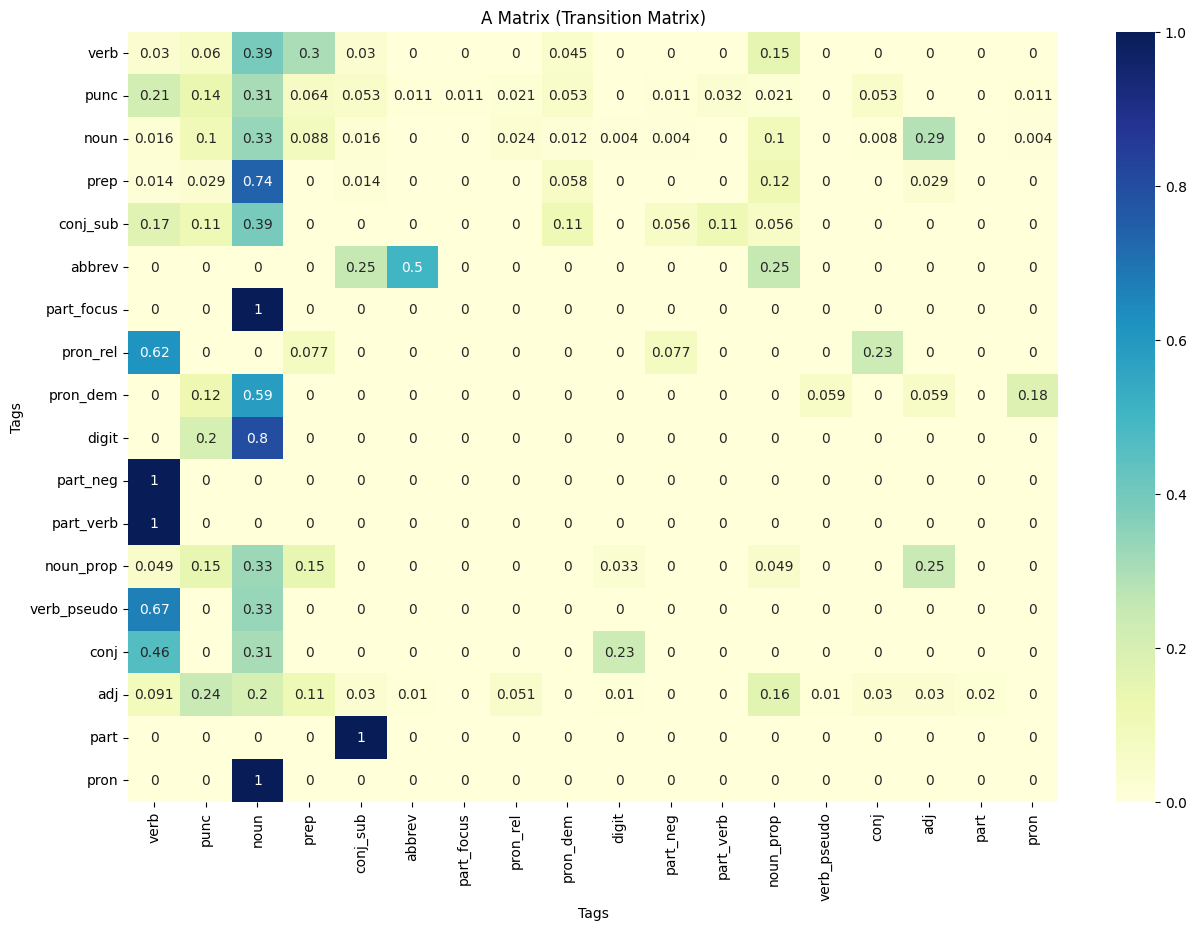

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(A, xticklabels=tag_set, yticklabels=tag_set, cmap="YlGnBu", cbar=True,annot=True)
plt.title("A Matrix (Transition Matrix)")
plt.xlabel("Tags")
plt.ylabel("Tags")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

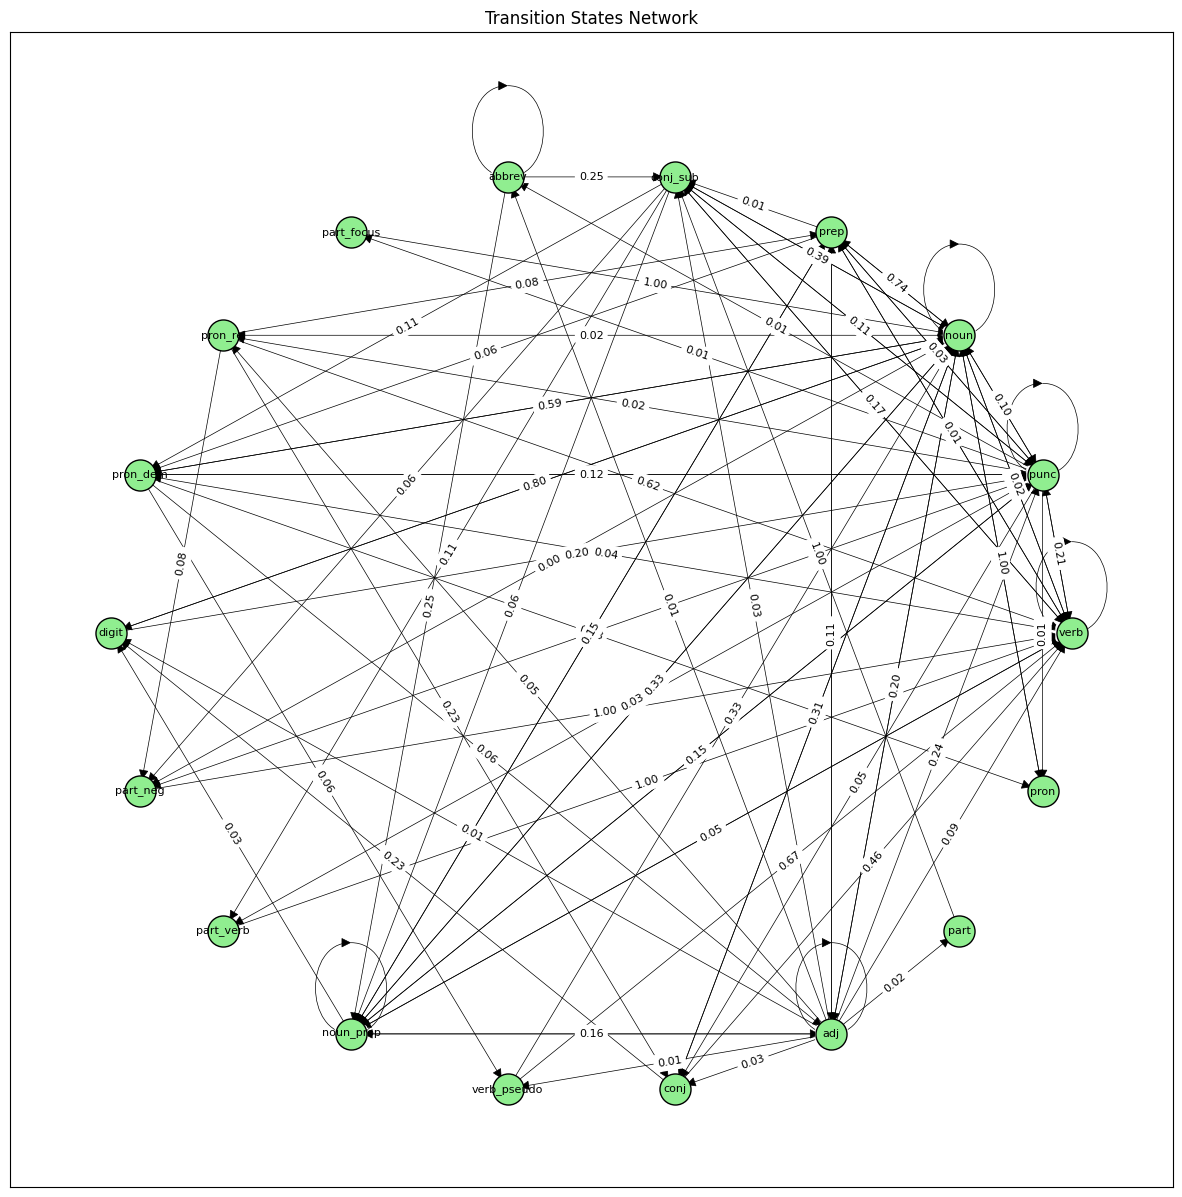

In [ ]:
transition_matrix = A
# Create a directed graph
G = nx.DiGraph()
# Add nodes with their tag names
for tag in tag_set:
    G.add_node(tag)
# Add edges with weights from the transition matrix
for i, from_tag in enumerate(tag_set):
    for j, to_tag in enumerate(tag_set):
        probability = transition_matrix[i, j]
        if probability > 0:  # Only add edges with non-zero probability
            G.add_edge(from_tag, to_tag, weight=probability)
# Set up the figure size
plt.figure(figsize=(15, 15))  # Increase the figure size
# Draw the graph
pos = nx.circular_layout(G)  # Position nodes using spring layout
edges = G.edges(data=True)
# Draw nodes with larger size
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgreen', edgecolors='black')
# Draw edges with increased width
nx.draw_networkx_edges(G, pos, width=0.5, arrowstyle='-|>', arrowsize=15)
# Draw edge labels with increased font size
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in edges}, font_size=8)
# Draw node labels with larger font size
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
plt.title("Transition States Network")
plt.show()


In [ ]:
for i,(testSent,realTag) in enumerate(zip(testSentences,testTags)):
    observations = [word2idx[word] for word in tokenizer.simple_word_tokenize(normalize_arabic(testSent))]
    best_path,dpMatrix,bpMatrix = viterbi(observations, pi, A, B)
    best_tags = [idx2tag[idx] for idx in best_path]
    print(f"F1Score-Sent{i+1}::{f1_score([tag2idx[t] for t in realTag]  , best_path, average='macro')}")

F1Score-Sent1::0.7965367965367965
F1Score-Sent2::0.7534013605442176
F1Score-Sent3::0.7999999999999999
F1Score-Sent4::0.968421052631579
F1Score-Sent5::0.025974025974025976


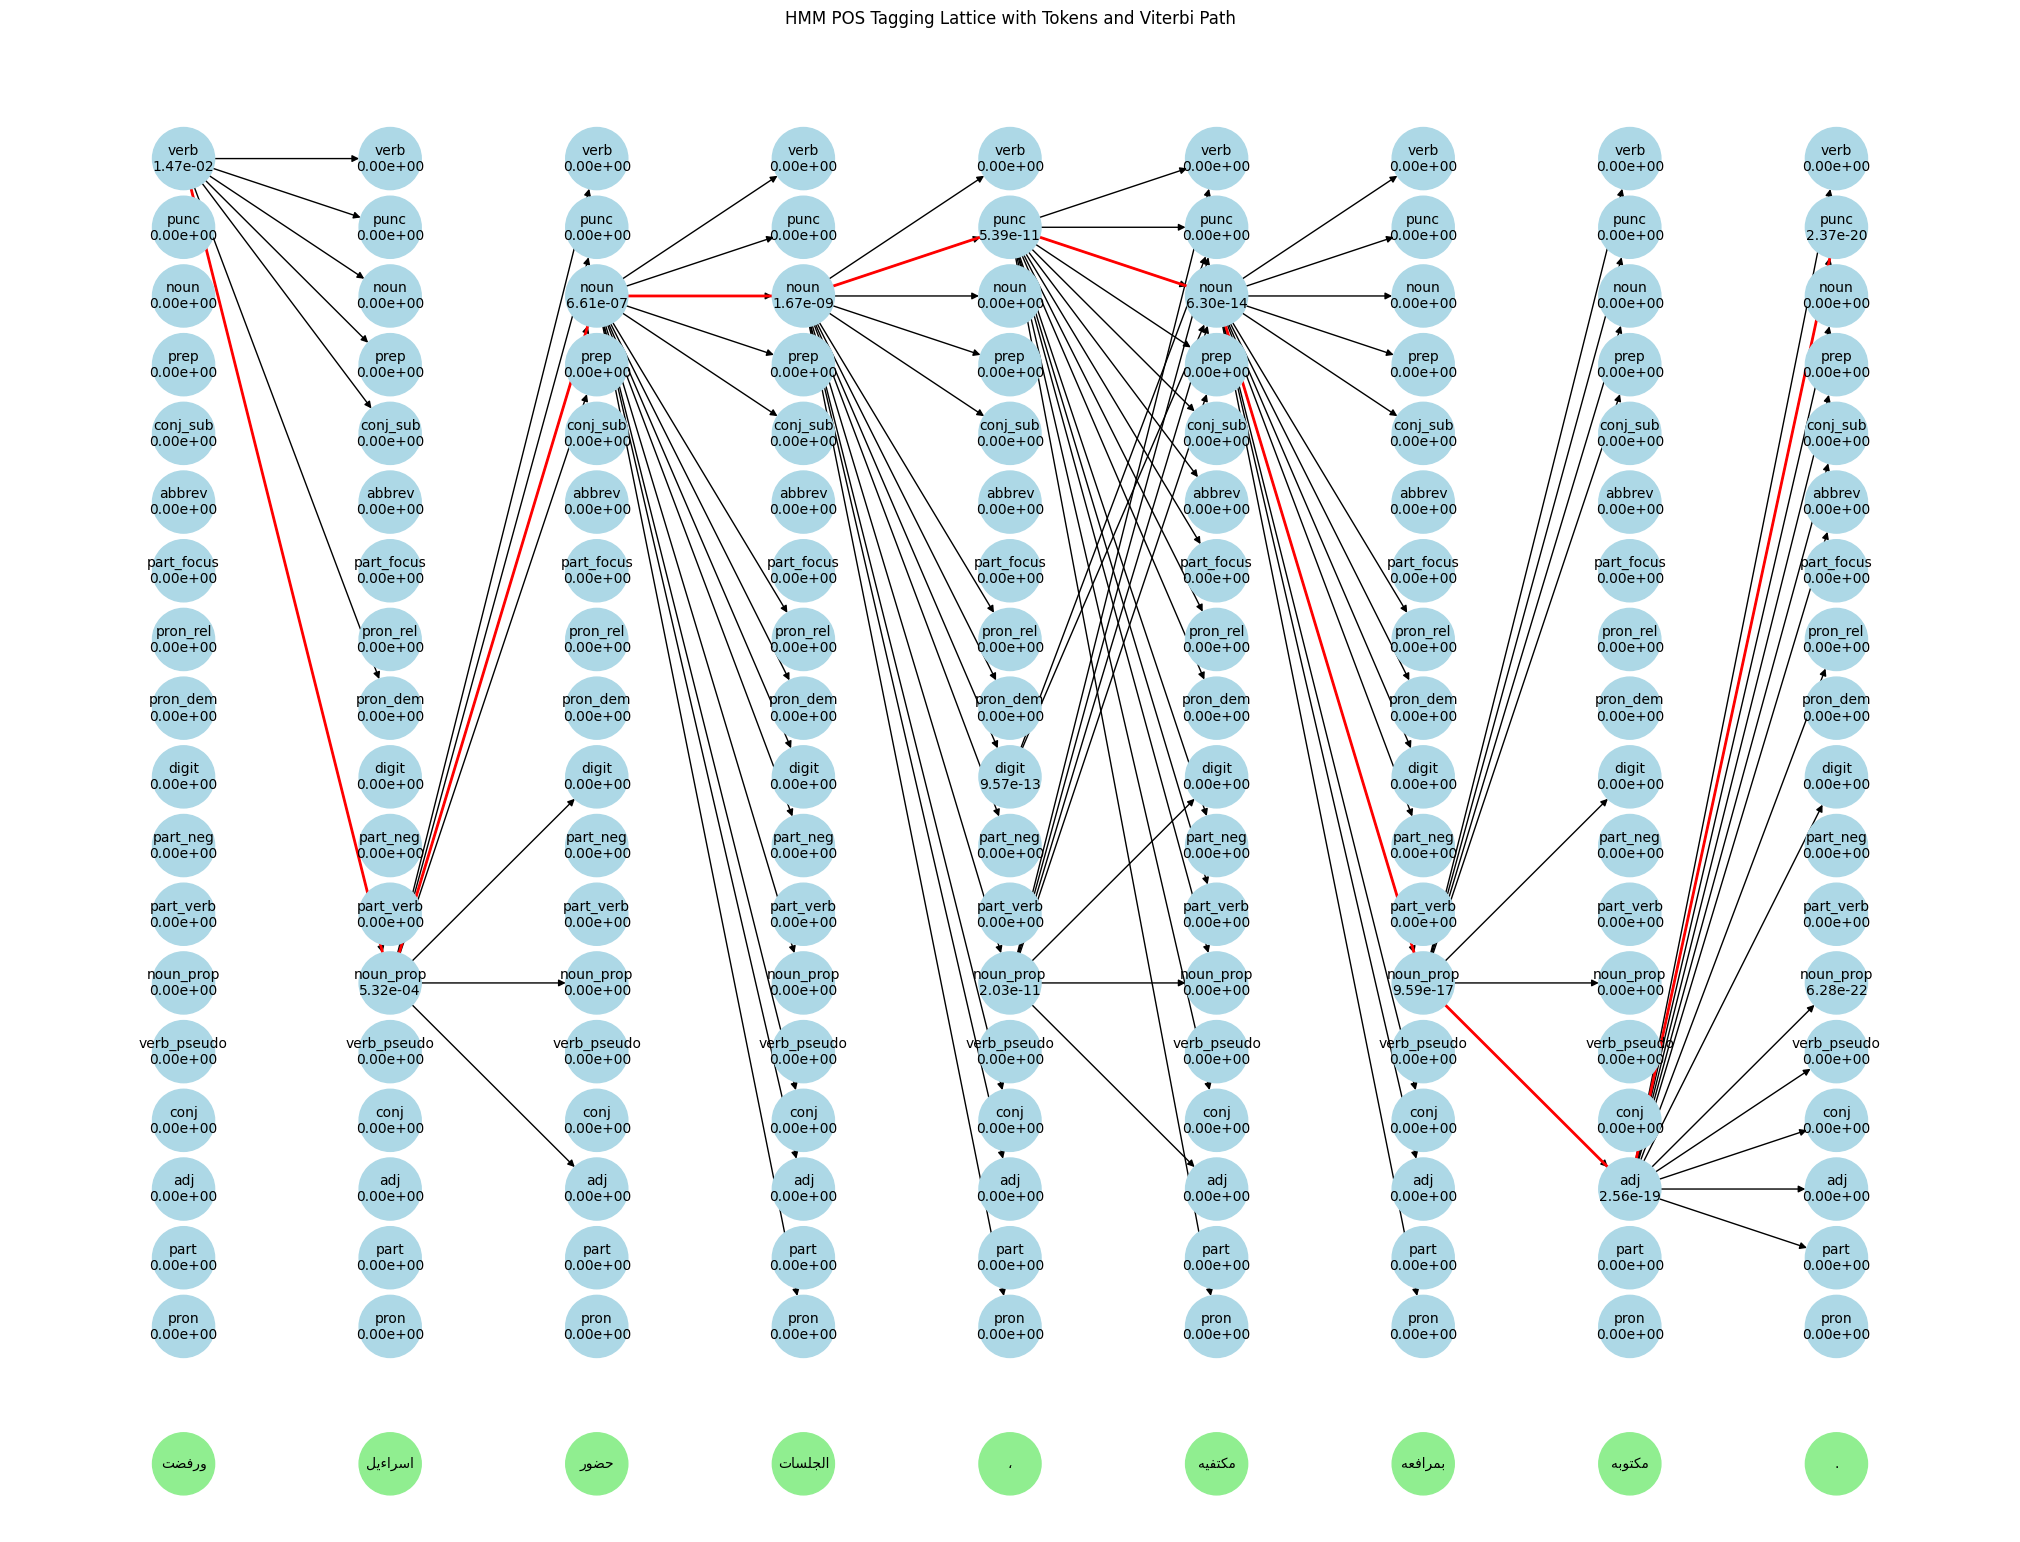

In [ ]:
observationsForTest=[word2idx[word] for word in tokenizer.simple_word_tokenize(normalize_arabic(testSentences[2]))]
plot_lattice(observationsForTest, pi, A, B, tokenizer.simple_word_tokenize(normalize_arabic(testSentences[2])))

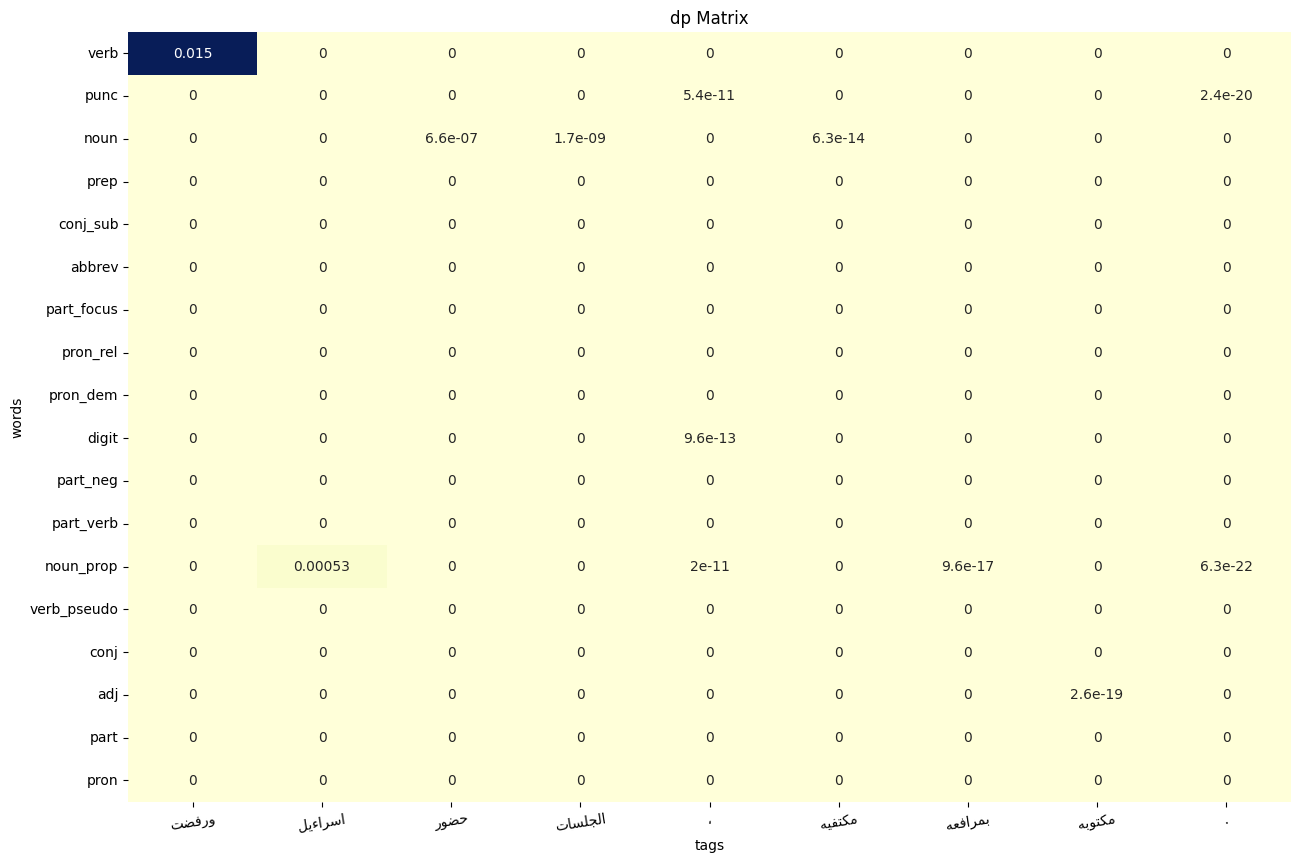

In [ ]:
best_path,dpMatrix,bpMatrix = viterbi(observationsForTest, pi, A, B)
plt.figure(figsize=(15,10))
sns.heatmap(dpMatrix, xticklabels=[get_display(arabic_reshaper.reshape(idx2word[w])) for w in observationsForTest], yticklabels=tag_set, cmap="YlGnBu", cbar=False,annot=True)
plt.title("dp Matrix")
plt.xlabel("tags")
plt.ylabel("words")
plt.xticks(rotation=9)
plt.yticks(rotation=0)
plt.show()

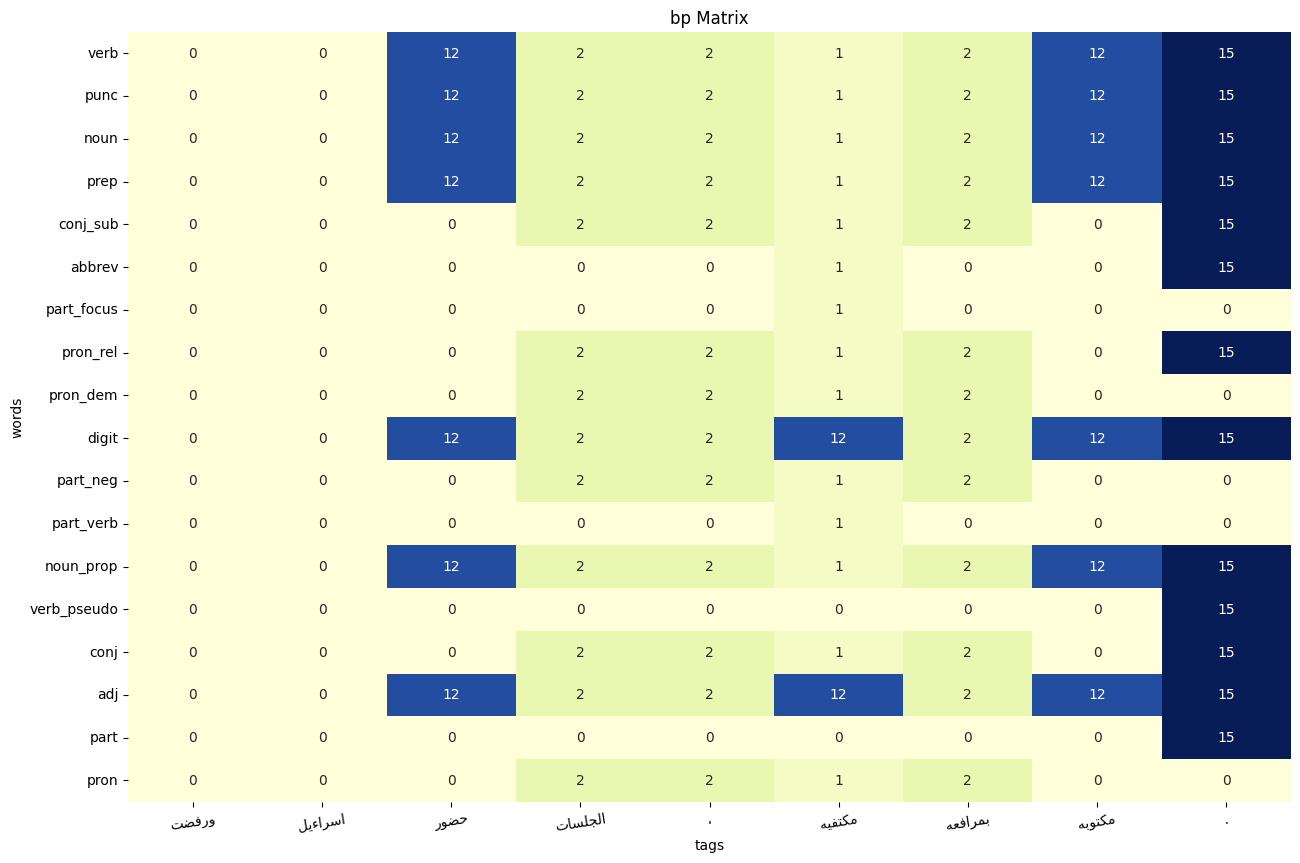

In [ ]:
best_path,dpMatrix,bpMatrix = viterbi(observationsForTest, pi, A, B)
plt.figure(figsize=(15,10))
sns.heatmap(bpMatrix, xticklabels=[get_display(arabic_reshaper.reshape(idx2word[w])) for w in observationsForTest], yticklabels=tag_set, cmap="YlGnBu", cbar=False,annot=True)
plt.title("bp Matrix")
plt.xlabel("tags")
plt.ylabel("words")
plt.xticks(rotation=9)
plt.yticks(rotation=0)
plt.show()